In [1]:
#
# Looks at envelopes of surface elevation and their spectra
# this checks on the normalisations necessary to get the 
# spectra of envelope squared and envelope from the 2D wave spectrum
# following Rice (1941 - p 131)
# First created :      M. de Carlo    2022/04/23
#

### MATPLOTLIB & SCIPY LIRAIRIES ##############""
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.text as mtext
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.cm as cmx 
import numpy as np
import scipy.special as sps # function erf
import scipy.signal as spsi # function fftconvolve
import scipy.interpolate as spi
import scipy.integrate as spint
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})
from simulator_functions import *
from altimetry_processing_functions import *

In [2]:
# In this first example we define the wave spectrum direcly on the kx,ky grid 
# that is the Fourier transform of the x,y grid we want for the sea surface

# kX, kY : grid of wavenumbers = 2 * pi /wavelength
# steps : dkx and dky, with nx and ny values. dkx = 2*pi/(dx*nx)
# x, y : grid of real x,y : nx values with a dx step. 
noise= 0
## ---  physical surface definition
# size of simulated sea surface in x and y
nx = 4048
ny = 4048
dx = 10 # [m]
dy = 10 # [m]

## --- defines spectrum
theta_m=60
D=2000
T0=12
Hs = 16
Lp=9.81/np.pi*T0**2;
kp=2*np.pi/Lp;sx=kp*0.1;sy=sx;

In [2]:
Z2D_def, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,Hs=Hs,
                         sk_theta=sx,sk_k=sy,typeSpec='Gaussian')

# Z1, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,
#                                       nk=1001,nth=36,klims=(0.0002,0.2),n=4,typeSpec='PM')

# Makes a surface with random phases using a seed (4th argument)
S2D_r,S2D_i,X,Y,kx,rg,dkx,dky= surface_from_Z1kxky_uniform_phase(Z2D_def,kX,kY,10) 

Hs for Gaussian :  15.999999999999899


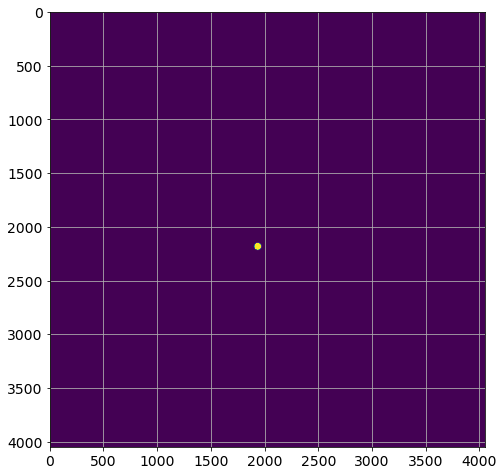

In [3]:
fig,ax=plt.subplots(figsize=(8,8))
plt.imshow(np.fliplr(np.transpose(Z2D_def)),vmin=0, vmax=10000)

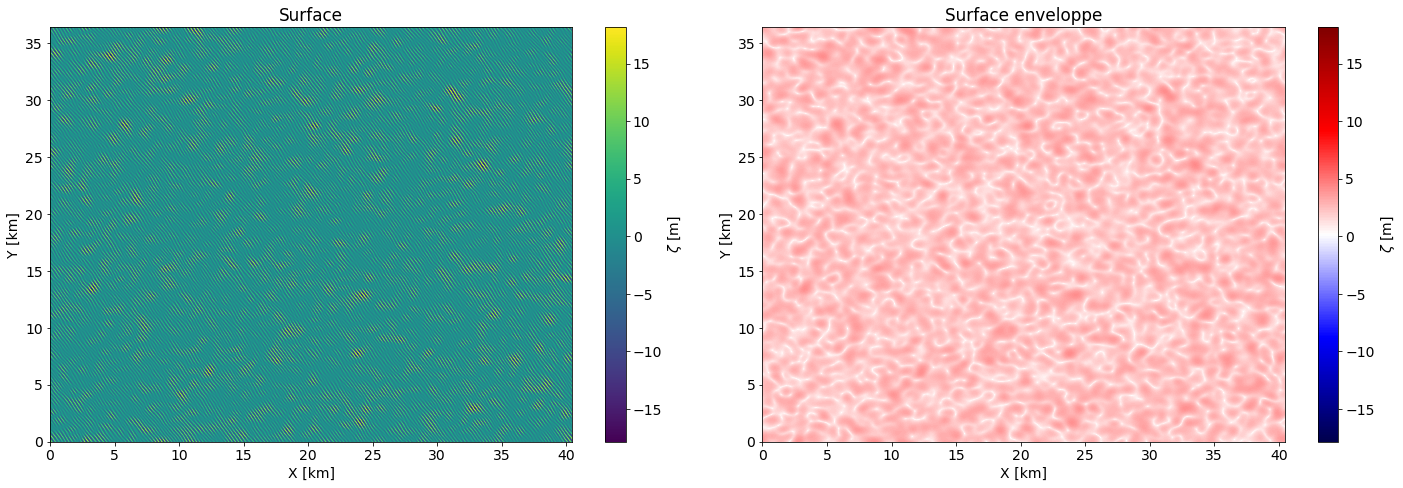

In [162]:
## Figure Surface et Surface Enveloppe ###########################""
fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)

im=axs[0].pcolormesh(X/1000,Y/1000,S2D_r,cmap='viridis',norm = mcolors.Normalize(vmin=S2D_r.min(), vmax=S2D_r.max()))
_=plt.colorbar(im,ax=axs[0],label='$\zeta$ [m]')
_=axs[0].set_xlabel('X [km]')
_=axs[0].set_ylabel('Y [km]')
_=axs[0].set_title('Surface')


A = np.sqrt(S2D_r**2+S2D_i**2)
B=np.sqrt(A)

im=axs[1].pcolormesh(X/1000,Y/1000,B,cmap='seismic',norm = mcolors.Normalize(vmin=S2D_r.min(), vmax=S2D_r.max()))
_=plt.colorbar(im,ax=axs[1],label='$\zeta$ [m]')

_=axs[1].set_xlabel('X [km]')
_=axs[1].set_ylabel('Y [km]')
_=axs[1].set_title('Surface enveloppe')
_=plt.tight_layout()

In [3]:
# Checking on what convolution in numpy really is: not circular convolution !!!
# let us define "myconv" as the circular convolution we need. 
# This is OK here because our surface is periodic and the FFT gives no funny effects ... 
# warning this convolution does not flip the second array ... need to be flipped before

import numpy as np
def myconv(x, h):
    assert np.shape(x) == np.shape(h), 'Inputs to periodic convolution '\
                               'must be of the same period, i.e., shape.'

    X = np.fft.fft(x)
    H = np.fft.fft(h)

    return np.real(np.fft.ifft(np.multiply(X, H)))

# and here is a quick verification

a=[2.0,3.0]
b=[1.0,0.5]
print('this is the standard non-circular convolution:',np.convolve(a,b, 'same'))
c=myconv(a,b)
print('this is my circular convolution:              ',c)
print(a[0]*b[0]+a[1]*b[-1],a[0]*b[1]+a[1]*b[0])

this is the standard non-circular convolution: [2. 4.]
this is my circular convolution:               [3.5 4. ]
3.5 4.0


In [6]:
isplot = 1
isprints = 1
Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc

In [4]:
## exemple Welch 1D 
## function to extract vector into tiles
def extract_Welch_tiles_1D(A,nxtile):
    # nxtiles : nb of pixels by tiles
    nxA = len(A)
#     nxtile = int(nxA//Ntiles)
    Ntiles = int(nxA//nxtile)
    shx = int(nxtile//2)
    Ntiles_overlap = 2*Ntiles-1
    
    extract= np.zeros((Ntiles_overlap,nxtile))
    for windows in range(Ntiles_overlap):
        if windows < Ntiles:
            i1 = int(windows + 1)
            extract[windows,:]=A[nxtile*(i1-1):nxtile*i1]
        elif windows >= Ntiles:
            i1 = int((windows-Ntiles)+ 1)
            extract[windows,:]=A[nxtile*(i1-1)+shx:nxtile*i1+shx]
    
    return extract, Ntiles_overlap

In [8]:
print(Z2D_def.shape)
print(kx.shape)
print(kx)

(4048, 4048)
(4048,)
[-0.31415927 -0.31400405 -0.31384883 ...  0.31369361  0.31384883
  0.31400405]


In [9]:
# investigate integration over total signal #############################
isplot=0
Hss = np.arange(1,20)
nHs=len(Hss)
Lp=9.81/np.pi*T0**2;
kp=2*np.pi/Lp;sx=kp*0.1;sy=sx;
slope = np.zeros(nHs)
inter = np.zeros(nHs)
Hs_from_surf2D = np.zeros(nHs)
Hs_from_surf1D = np.zeros(nHs)
equiv_Hs_from_env = np.zeros(nHs)
estim_Hstot_from_env = np.zeros(nHs)
estim_Hstot_from_env_spec = np.zeros(nHs)
estim_Hstot_from_env_spec0 = np.zeros(nHs)
Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc
nLL = 15
LLs=np.linspace(1000,6000,nLL)

Hs2_means = np.zeros((nLL,nHs))
Hs_means_2 = np.zeros((nLL,nHs))
Hs2_stds = np.zeros((nLL,nHs))
Hs_stds_2 = np.zeros((nLL,nHs))
Hs2_estimated_mean = np.zeros((nLL,nHs))
Hs2_estimated_std = np.zeros((nLL,nHs))
Hs_estimated_mean = np.zeros((nLL,nHs))
Hs_estimated_std = np.zeros((nLL,nHs))
var_env_above = np.zeros((nLL,nHs))
var_env2_above = np.zeros((nLL,nHs))
Hs2_estimated_env = np.zeros((nLL,nHs))
Hs2_estimated_env2 = np.zeros((nLL,nHs))

for ihs,Hs in enumerate(Hss):
    Z2D_def, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,Hs=Hs,
                             sk_theta=sx,sk_k=sy,typeSpec='Gaussian')

    # Z1, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,
    #                                       nk=1001,nth=36,klims=(0.0002,0.2),n=4,typeSpec='PM')

    # Makes a surface with random phases using a seed (4th argument)
    S2D_r,S2D_i,X,Y,kx,rg,dkx,dky= surface_from_Z1kxky_uniform_phase(Z2D_def,kX,kY,10) 
    ### Get a equivalent 2D spectrum from DFT of the surface ################
    # -- to verify the coefficients ------------------------------------
    Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

    ### 1D spectrum from integration over ky 
    Z1D_def = (np.sum(Z2D_def,axis=0))*dky
    Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

    ### Generate a 1D surface based on 1D spectrum (1 realisation) #########
    rng = np.random.default_rng(0)
    rg = rng.uniform(low=0.0, high=1.0, size=(nx))
    # -- from original 1D spectrum (from 2D)
    zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
    S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
    S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

    ### Envelope squared A2D and envelope B2D ###############################################
    # -- 2D env
    A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
    B2D = np.sqrt(A2D) 
    A2D = A2D-np.mean(A2D.flatten())
#     B2D = B2D-np.mean(B2D.flatten())

    # ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
    Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
    Spec_env1_2D = np.abs(np.fft.fft2(B2D-np.mean(B2D.flatten()),norm='forward'))**2/(dky*dkx)
    Spec_env1_2D_DC = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

    # integration over y <=> integration over realisations 
    Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky
    Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky
    Spec_env1_DC_from_2D = np.sum(Spec_env1_2D_DC,axis=0)*dky*dkx

    Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)
    Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D)
    Spec_env1_DC_from_2D_shifted = np.fft.fftshift(Spec_env1_DC_from_2D)
    
    Spec_env1_func = spi.interp1d(kx,Spec_env1_from_2D_shifted)
    Spec_env2_func = spi.interp1d(kx,Spec_env2_from_2D_shifted)

    # -- 1D env
    A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
    B1D = np.sqrt(A1D) 
    A1D = A1D-np.mean(A1D.flatten())
    # B1D = B1D-np.mean(B1D.flatten())
    var1_from2D_spec = np.sum(Spec_env1_from_2D_shifted)*dkx
    estim_Hstot_from_env[ihs] = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)
    estim_Hstot_from_env_spec0[ihs] = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + var1_from2D_spec)
    estim_Hstot_from_env_spec[ihs] = np.sqrt(8)*np.sqrt(Spec_env1_DC_from_2D[0] + var1_from2D_spec)
    equiv_Hs_from_env[ihs] = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
    Hs_from_surf1D[ihs] = 4*np.std(S1D_r)
    Hs_from_surf2D[ihs] = 4*np.std(S2D_r)

    print('---- Hs from Std of surface : ----------------------------------')
    print('1D :           4*std(S1D_r) = ',Hs_from_surf1D[ihs])
    print('2D :           4*std(S2D_r) = ',Hs_from_surf2D[ihs])
    print(' ')
    print('---- Hs from envelope : --------------')
    print('equivalent (2 * env ~ Hrms)  = ',equiv_Hs_from_env[ihs])
    print('estimation (sqrt(8)*sqrt(mean(env)**2 + std(env)**2))  = ',estim_Hstot_from_env[ihs])
    print('')
    mean_env = np.mean(B1D)
    
    for il,LL in enumerate(LLs):
        Nfoot = int(LL//dx)
        kc=2*np.pi/LL
        
        var_env_above[il,ihs] = spint.quad(Spec_env1_func,kc,kx.max())[0]+spint.quad(Spec_env1_func,kx.min(),-kc)[0]
        var_env2_above[il,ihs] = spint.quad(Spec_env2_func,kc,kx.max())[0]+spint.quad(Spec_env2_func,kx.min(),-kc)[0]
#         var_env2_conv_above[il,ihs]=spint.quad(conv_1Da_func,kc,kx.max())[0]+spint.quad(conv_1Da_func,kx.min(),-kc)[0]
        
        footprints_S1D, Ntiles= extract_Welch_tiles_1D(S1D_r,Nfoot)
        footprints_Env, Ntiles= extract_Welch_tiles_1D(B1D,Nfoot)
#         print('LL = ',LL,', shape footprints = ',np.shape(footprints_S1D))
        Hs_footprints_disk_2 = 4**2*np.var(footprints_S1D,axis=1,ddof=0)
        Hs_footprints_disk = np.sqrt(Hs_footprints_disk_2)
        env_means_disk = np.mean(footprints_Env,axis=1)
        env_var_disk = np.var(footprints_Env,axis=1,ddof=1)

        Hs2_means[il,ihs] = np.mean(Hs_footprints_disk_2)
        Hs_means_2[il,ihs] = np.mean(Hs_footprints_disk)**2
        Hs2_stds[il,ihs] = np.std(Hs_footprints_disk_2)
        Hs_stds_2[il,ihs] = np.var(Hs_footprints_disk)

        Hs2_estimated_footprint = 8*(env_means_disk**2 + env_var_disk)
        Hs2_estimated_mean[il,ihs] = np.mean(Hs2_estimated_footprint) # THIS one is similar to local Hs !!!! NICELY DONE !
        Hs2_estimated_std[il,ihs] = np.std(Hs2_estimated_footprint)
        Hs2_estimated_env[il,ihs] = 8*(Spec_env1_DC_from_2D[0]+var_env_above[il,ihs])
        Hs2_estimated_env2[il,ihs] = 8*(Spec_env1_DC_from_2D[0]+var_env2_above[il,ihs])
        
        Hs_estimated_mean[il,ihs] = np.mean(np.sqrt(Hs2_estimated_footprint)) # THIS one is similar to local Hs !!!! NICELY DONE !
        Hs_estimated_std[il,ihs] = np.std(np.sqrt(Hs2_estimated_footprint))

    res = stats.linregress(np.sqrt(Hs_stds_2[:,ihs]), np.sqrt(Hs2_estimated_std[:,ihs]))
    slope[ihs]=res.slope
    inter[ihs]=res.intercept

Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  0.9999999999999937


KeyboardInterrupt: 

Ratio Hs_from_surf/Hs_def =  1.0540925533894956


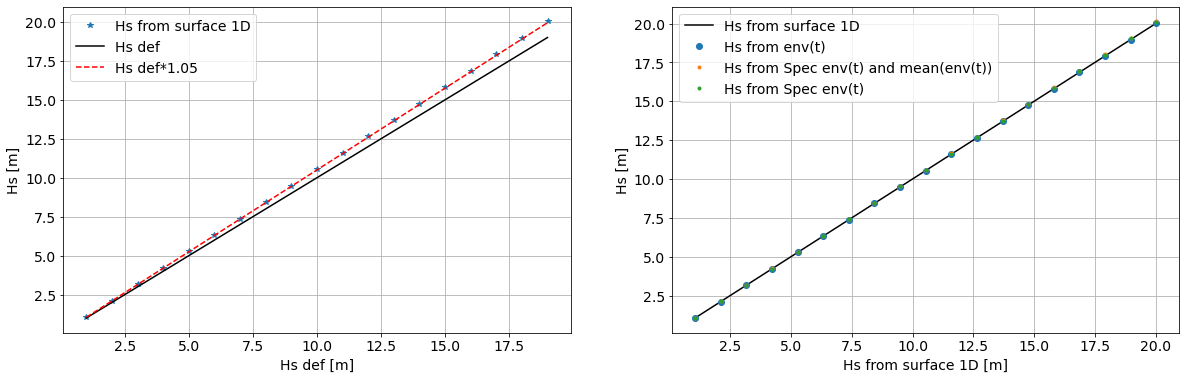

In [7]:
# --- Ratio Hs defined vs Hs from std surface = 1.05
res = stats.linregress(Hss,Hs_from_surf1D)
print('Ratio Hs_from_surf/Hs_def = ',res.slope)
fig,axs=plt.subplots(1,2,figsize=(20,6))
_=axs[0].plot(Hss,Hs_from_surf1D,'*',label='Hs from surface 1D')
_=axs[0].plot(Hss,Hss,'-k',label='Hs def')
_=axs[0].plot(Hss,Hss*1.05,'--r',label='Hs def*1.05')
_=axs[0].set_xlabel('Hs def [m]')
_=axs[0].set_ylabel('Hs [m]')
_=axs[0].legend()

# _=axs[1].plot(Hss,Hs_from_surf1D,'*',label='Hs from surface 1D')
_=axs[1].plot(Hs_from_surf1D,Hs_from_surf1D,'-k',label='Hs from surface 1D')#def')
_=axs[1].plot(Hs_from_surf1D,estim_Hstot_from_env,'o',label='Hs from env(t)')
_=axs[1].plot(Hs_from_surf1D,estim_Hstot_from_env_spec0,'.',label='Hs from Spec env(t) and mean(env(t))')
_=axs[1].plot(Hs_from_surf1D,(estim_Hstot_from_env_spec),'.',label='Hs from Spec env(t)')
_=axs[1].set_xlabel('Hs from surface 1D [m]')
_=axs[1].set_ylabel('Hs [m]')
_=axs[1].legend()

In [58]:
# investigate variances r/r partial integration of spectrum #######################

isplot=0
Hss = np.arange(4,20,4)
nHs=len(Hss)
T0=12
Lp=9.81/np.pi*T0**2;
kp=2*np.pi/Lp;
sx=kp*0.14
sy=sx;

nseed= 8
slope = np.zeros(nHs)
inter = np.zeros(nHs)
Hs_from_surf2D = np.zeros(nHs)
Hs_from_surf1D = np.zeros(nHs)
equiv_Hs_from_env = np.zeros(nHs)
estim_Hstot_from_env = np.zeros(nHs)
estim_Hstot_from_env_spec = np.zeros(nHs)
estim_Hstot_from_env_spec0 = np.zeros(nHs)
Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
# kc=2*np.pi/Lc
nLL = 20
L_low = 2*np.pi/(1.72*sx)#2.5*sx)
LLs=np.flip(np.linspace(500,8000,nLL))
Ntmax = int(2*(nx//(LLs.min()//dx))-1)
# # to study the limit
# L_low = 2*np.pi/(2*sx)
# LLs=np.flip(np.linspace(1000,L_low,nLL))

mean_sum_spec_env_without0 = np.zeros((nLL,nHs))
std_sum_spec_env_without0 = np.zeros((nLL,nHs))
sum_spec_env = np.zeros((nLL,nHs))
Hs2_means = np.zeros((nLL,nHs))
Hs_means_2 = np.zeros((nLL,nHs))
Hs2_stds = np.zeros((nLL,nHs))
Hs_stds_2 = np.zeros((nLL,nHs))
Hs2_estimated_mean = np.zeros((nLL,nHs))
Hs2_estimated_std = np.zeros((nLL,nHs))
Hs_estimated_mean = np.zeros((nLL,nHs))
Hs_estimated_std = np.zeros((nLL,nHs))
var_env_above = np.zeros((nLL,nHs,nseed))
var_env_2D_above = np.zeros((nLL,nHs,nseed))
var_env_welch = np.zeros((nLL,nHs,nseed))
var_env_footspec = np.zeros((nLL,nHs,nseed))
Hs_footprints_disk_2_vec = np.zeros((nLL,nHs,nseed,Ntmax))
env_means_disk_vec = np.zeros((nLL,nHs,nseed,Ntmax))
env_var_disk_vec = np.zeros((nLL,nHs,nseed,Ntmax))

Hs2_estimated_env = np.zeros((nLL,nHs))
Hs2_estimated_env2 = np.zeros((nLL,nHs))

if isplot:
    fig,axs = plt.subplots(2,2,figsize=(20,14))
    fig2,axs2 = plt.subplots(2,2,figsize=(20,14))
spec_funcs = []
for ihs,Hs in enumerate(Hss):
    Z2D_def, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,Hs=Hs,
                             sk_theta=sx,sk_k=sy,typeSpec='Gaussian')
    
    # Makes a surface with random phases using a seed (4th argument)
    S2D_r,S2D_i,X,Y,kx,rg,dkx,dky= surface_from_Z1kxky_uniform_phase(Z2D_def,kX,kY,10) 
#     ### Get a equivalent 2D spectrum from DFT of the surface ################
#     # -- to verify the coefficients ------------------------------------
#     Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

    ### 1D spectrum from integration over ky 
    Z1D_def = (np.sum(Z2D_def,axis=0))*dky # from -kmax to + kmax
    Z1D_def_noshift = np.fft.ifftshift(Z1D_def) #  from 0 to kmax + -kmax to 0
    spec_funcs0 = []
    ### Generate a 1D surface based on 1D spectrum (1 realisation) #########
    for isee in range(nseed):
        rng = np.random.default_rng(isee)
        rg = rng.uniform(low=0.0, high=1.0, size=(nx))
        # -- from original 1D spectrum (from 2D)
        zhats=np.sqrt(2*Z1D_def_noshift*dkx)*np.exp(1j*2*np.pi*rg)
        S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
        S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

        ### Envelope squared A2D and envelope B2D ###############################################
        # -- 2D env --------------- --------------- --------------- ---------------
        A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
        B2D = np.sqrt(A2D) 
        A2D = A2D-np.mean(A2D.flatten())
    #     B2D = B2D-np.mean(B2D.flatten())

        # ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
        Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
        Spec_env1_2D = np.abs(np.fft.fft2(B2D-np.mean(B2D.flatten()),norm='forward'))**2/(dky*dkx)
        Spec_env1_2D_DC = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

        # integration over y <=> integration over realisations 
        Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky # 0 to kmax  and -kmax to 0
        Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky # 0 to kmax  and -kmax to 0
        Spec_env1_DC_from_2D = np.sum(Spec_env1_2D_DC,axis=0)*dky # 0 to kmax  and -kmax to 0

        Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D) # -kmax to kmax
        Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D) # -kmax to kmax
        Spec_env1_DC_from_2D_shifted = np.fft.fftshift(Spec_env1_DC_from_2D) # -kmax to kmax

        Spec_env1_2D_func = spi.interp1d(kx,Spec_env1_from_2D_shifted)
        Spec_env1_DC_2D_func = spi.interp1d(kx,Spec_env1_DC_from_2D_shifted)
        Spec_env2_2D_func = spi.interp1d(kx,Spec_env2_from_2D_shifted)
        
        spec_funcs0.append(Spec_env1_DC_2D_func)
        # -- 1D env --------------- --------------- --------------- ---------------
        A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
        B1D = np.sqrt(A1D) 
        A1D = A1D-np.mean(A1D.flatten())
        # B1D = B1D-np.mean(B1D.flatten())
        Spec_env2_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/dkx # 0 to kmax  and -kmax to 0
        Spec_env1_1D = np.abs(np.fft.fft(B1D-np.mean(B1D.flatten()),norm='forward'))**2/(dkx) # 0 to kmax  and -kmax to 0
        Spec_env1_1D_DC = np.abs(np.fft.fft(B1D,norm='forward'))**2/(dkx) # 0 to kmax  and -kmax to 0

        Spec_env2_1D_shifted = np.fft.fftshift(Spec_env2_1D) # -kmax to kmax
        Spec_env1_1D_shifted = np.fft.fftshift(Spec_env1_1D) # -kmax to kmax
        Spec_env1_DC_1D_shifted = np.fft.fftshift(Spec_env1_1D_DC) # -kmax to kmax

        Spec_env1_1D_func = spi.interp1d(kx,Spec_env1_1D_shifted)
        Spec_env2_1D_func = spi.interp1d(kx,Spec_env2_1D_shifted)

        var1_from2D_spec = np.sum(Spec_env1_from_2D_shifted)*dkx
        var1_from1D_spec = np.sum(Spec_env1_1D_shifted)*dkx

        estim_Hstot_from_env[ihs] = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)
        estim_Hstot_from_env_spec0[ihs] = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + var1_from2D_spec)
        estim_Hstot_from_env_spec[ihs] = np.sqrt(8)*np.sqrt(Spec_env1_DC_from_2D[0] + var1_from2D_spec)
        equiv_Hs_from_env[ihs] = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
        Hs_from_surf1D[ihs] = 4*np.std(S1D_r)
        Hs_from_surf2D[ihs] = 4*np.std(S2D_r)
        '''
        print('---- Hs from Std of surface : ----------------------------------')
        print('1D :           4*std(S1D_r) = ',Hs_from_surf1D[ihs])
        print('2D :           4*std(S2D_r) = ',Hs_from_surf2D[ihs])
        print(' ')
        print('---- Hs from envelope : --------------')
        print('equivalent (2 * env ~ Hrms)  = ',equiv_Hs_from_env[ihs])
        print('estimation (sqrt(8)*sqrt(mean(env)**2 + std(env)**2))  = ',estim_Hstot_from_env[ihs])
        print('')
        '''
        mean_env = np.mean(B1D)

        if (isplot) and (Hs%4==0):
            axs[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(kx,Spec_env1_from_2D_shifted,'--ok',zorder=100) 
            axs[((Hs//4)-1)//2,((Hs//4)-1)%2].set_title('Hs = '+str(Hs))
    #         axs[((Hs//4)-1)//2,((Hs//4)-1)%2].set_xscale('log')
    #         axs[((Hs//4)-1)//2,((Hs//4)-1)%2].set_yscale('log')
            axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].set_title('Hs = '+str(Hs))
            axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].set_xscale('log')
            axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].set_yscale('log')
        for il,LL in enumerate(LLs):
            Nfoot = int(LL//dx) # size of footprint
            kc=2*np.pi/(LL)

            footprints_S1D, Ntiles = extract_Welch_tiles_1D(S1D_r,Nfoot)
            footprints_Env, Ntiles = extract_Welch_tiles_1D(B1D-B1D.mean(),Nfoot) 
            # axis : nb of footprint = Ntiles, size footprint = Nfoot
            hann_weight = 0.5 - 0.5 * np.cos(2*np.pi*np.arange(Nfoot)/(Nfoot-1))
            hann_weight = np.tile(hann_weight,(Ntiles,1))
            U = np.mean(np.abs(hann_weight)**2)

            # --- var calculated from surface in footprint --------------
            Hs_footprints_disk_2 = np.var(footprints_S1D,axis=1,ddof=1)
            Hs_footprints_disk = np.sqrt(Hs_footprints_disk_2)

            # --- Spec for enveloppe in footprint -----
            spec_footprint_Env0 = np.abs(np.fft.fftshift(np.fft.fft(footprints_Env*hann_weight,
                                                                    norm='forward',axis=1)))**2
            freq_footprint_mkmax_kmax = np.fft.fftshift(np.fft.fftfreq(Nfoot, d=dx)*2*np.pi)
            dkxspec = freq_footprint_mkmax_kmax[1] - freq_footprint_mkmax_kmax[0]
            spec_footprint_Env = np.mean(spec_footprint_Env0/(dkxspec*U),axis=0)
            spec_footprint_Env_func = spi.interp1d(freq_footprint_mkmax_kmax,spec_footprint_Env)
            # --- Spec for enveloppe in footprint - welch -----
            freq_welch,spec_welch_Env = spsi.welch(B1D-B1D.mean(),fs = 2*np.pi/dx,
                                                   nperseg=Nfoot)#,noverlap = Nfoot-6 )
            spec_welch_Env_func = spi.interp1d(freq_welch,spec_welch_Env)

            # --- Definition KxMax -----------------------
            kxMax = np.min((kx.max(),freq_welch.max(),freq_footprint_mkmax_kmax.max()))
            # ----- Var from tot spec int -------------------------------------
            var_env_above[il,ihs,isee] = spint.quad(Spec_env1_1D_func,kc,kxMax)[0]+spint.quad(Spec_env1_1D_func,-kxMax,-kc)[0]
            var_env_2D_above[il,ihs,isee] = spint.quad(Spec_env1_2D_func,kc,kxMax)[0]+spint.quad(Spec_env1_2D_func,-kxMax,-kc)[0]
    #         var_env2_conv_above[il,ihs]=spint.quad(conv_1Da_func,kc,kx.max())[0]+spint.quad(conv_1Da_func,kx.min(),-kc)[0]

            var_env_welch[il,ihs,isee] = spint.quad(spec_welch_Env_func,kc,kxMax)[0]
            var_env_footspec[il,ihs,isee] = spint.quad(spec_footprint_Env_func,kc,kxMax)[0]+spint.quad(spec_footprint_Env_func,-kxMax,-kc)[0]

            # --- 
            sum_spec = np.sum(spec_footprint_Env0[:,np.abs(freq_footprint_mkmax_kmax)>0],axis=1)
            mean_sum_spec_env_without0[il,ihs] = np.mean(sum_spec)
            std_sum_spec_env_without0[il,ihs] = np.std(sum_spec)
    #         sum_spec_env[il,ihs] = np.sum(spec_footprint_Env,axis=1)
            kmin = np.min(freq_footprint_mkmax_kmax[freq_footprint_mkmax_kmax>0])

            if (isplot) and (Hs%4==0):
                A = Spec_env1_2D_func(freq_welch[:-1])
                B = np.mean(spec_footprint_Env0/(dkxspec*U),axis=0)[freq_footprint_mkmax_kmax>=0] - A
                C = spec_welch_Env[:-1]-A

                freq_footprint_0_kmax=freq_footprint_mkmax_kmax[freq_footprint_mkmax_kmax>=0]
    #             axs[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_footprint_mkmax_kmax,spec_footprint_Env.T/dkxspec,'-',alpha=0.5,color=plt.cm.jet(LL/LLs.max()),markersize=18)
                axs[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_footprint_mkmax_kmax,np.mean(spec_footprint_Env0/dkxspec,axis=0),
                                                       '*-',color=plt.cm.jet(LL/LLs.max()),markersize=12,markeredgecolor='k',zorder=0)
                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_footprint_0_kmax,np.abs(B),'*-',
                                                       color=plt.cm.jet(LL/LLs.max()),markersize=12,markeredgecolor='k')
                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_welch[:-1],np.abs(C),'o--',color=plt.cm.jet(LL/LLs.max())
                                                       ,markersize=12,markeredgecolor='w')
                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_welch[:-1],np.abs(C/B),'^:',color=plt.cm.jet(LL/LLs.max())
                                                       ,markersize=12,markeredgecolor='w')
                axs[((Hs//4)-1)//2,((Hs//4)-1)%2].plot(freq_welch,spec_welch_Env,'o--',color=plt.cm.jet(LL/LLs.max()),
                                                       markersize=12,markeredgecolor='k',zorder=1)

                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].axvline(kmin,color=plt.cm.jet(LL/LLs.max()),label=LL)
                axs2[((Hs//4)-1)//2,((Hs//4)-1)%2].legend()
                axs[((Hs//4)-1)//2,((Hs//4)-1)%2].axvline(kmin,color=plt.cm.jet(LL/LLs.max()),label=LL)
                axs[((Hs//4)-1)//2,((Hs//4)-1)%2].legend()
    #             axs[((Hs//4)-1)//2,((Hs//4)-1)%2].set_xlim((10**-4,10**-2))

            # --- calculate mean and var of env per footprint --------------------
            env_means_disk = np.mean(footprints_Env,axis=1)
            env_var_disk = np.var(footprints_Env,axis=1,ddof=1)

            # --- take the mean and std over tiles of Hs**2 --------------------
            Hs_footprints_disk_2_vec[il,ihs,isee,:Ntiles]=Hs_footprints_disk_2
            env_means_disk_vec[il,ihs,isee,:Ntiles]=env_means_disk
            env_var_disk_vec[il,ihs,isee,:Ntiles]=env_var_disk
            
            Hs2_means[il,ihs] = np.mean(Hs_footprints_disk_2)
            Hs2_stds[il,ihs] = np.std(Hs_footprints_disk_2)
            # --- take the mean**2 and std**2 over tiles of Hs --------------------
            Hs_means_2[il,ihs] = np.mean(Hs_footprints_disk)**2
            Hs_stds_2[il,ihs] = np.var(Hs_footprints_disk)

            # --- estimate Hs**2 mean and std from envelope equivalent Hs**2 ------------------------------
            Hs2_estimated_footprint = 8*(env_means_disk**2 + env_var_disk)
            Hs2_estimated_mean[il,ihs] = np.mean(Hs2_estimated_footprint) # THIS one is similar to local Hs !!!! NICELY DONE !
            Hs2_estimated_std[il,ihs] = np.std(Hs2_estimated_footprint)
            # --- estimate Hs**2 from spectrum of envelope -------------------------
            Hs2_estimated_env[il,ihs] = 8*(Spec_env1_DC_from_2D[0]+var_env_above[il,ihs,0])
            Hs2_estimated_env2[il,ihs] = 8*(Spec_env1_DC_from_2D[0]+var_env_2D_above[il,ihs,0])
            # --- estimate Hs mean and std from estimated Hs**2 from spectrum of envelope -------------------------
            Hs_estimated_mean[il,ihs] = np.mean(np.sqrt(Hs2_estimated_footprint)) # THIS one is similar to local Hs !!!! NICELY DONE !
            Hs_estimated_std[il,ihs] = np.std(np.sqrt(Hs2_estimated_footprint))

    spec_funcs.append(spec_funcs0)
    res = stats.linregress(np.sqrt(Hs_stds_2[:,ihs]), np.sqrt(Hs2_estimated_std[:,ihs]))
    slope[ihs]=res.slope
    inter[ihs]=res.intercept

Hs for Gaussian :  3.9999999999999676
Hs for Gaussian :  7.999999999999935
Hs for Gaussian :  11.999999999999778
Hs for Gaussian :  15.99999999999987


Lp = 9.81/np.pi*T0**2 = 449.6572776186701
sx = kp*0.1 =  0.0019562586591806972
lim = 2*np.pi / (3*sx) =  1070.6125657587381
2*pi / sx :  3211.837697276215
LL =  2078.9473684210525  x =  1.5449345885632426
LL =  1684.2105263157896  x =  1.9070286327577526
mean x =  1.7259816106604977


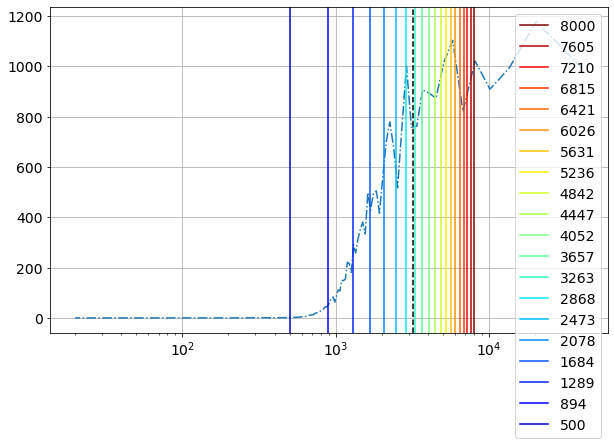

In [27]:
print('Lp = 9.81/np.pi*T0**2 =',Lp)
print('sx = kp*0.1 = ',sx)
print('lim = 2*np.pi / (3*sx) = ',2*np.pi / (3*sx))
plt.plot(2*np.pi/kx,Spec_env1_from_2D_shifted,'-.')

oldLLs = np.flip(np.linspace(1000,2*np.pi / (2*sx),6))
# LLs 
# for LL in oldLLs:
#     plt.axvline(2*np.pi/(LL),color=plt.cm.jet(LL/oldLLs.max()),linestyle='--',label=np.floor(LL))
for LL in LLs:
    plt.axvline((LL),color=plt.cm.jet(LL/LLs.max()),linestyle='-',label=int(np.floor(LL)))

plt.axvline(2*np.pi/sx,color='k',linestyle='--')
print('2*pi / sx : ',2*np.pi/sx)
# plt.axvline(2.5*sx,color='k',linestyle='-.')
# plt.axvline(3*sx,color='k',linestyle=':',linewidth=3)
_=plt.legend()
_=plt.xscale('log')

print('LL = ',LLs[-5],' x = ',2*np.pi/(LLs[-5]*sx))
print('LL = ',LLs[-4],' x = ',2*np.pi/(LLs[-4]*sx))
nxsx = 0.5*((2*np.pi/(LLs[-5]*sx)) + (2*np.pi/(LLs[-4]*sx)))
print('mean x = ',nxsx)
# plt.axvline(nxsx*sx,color='k',linestyle='-.')
# plt.axvline(3*sx,color='k',linestyle=':',linewidth=3)

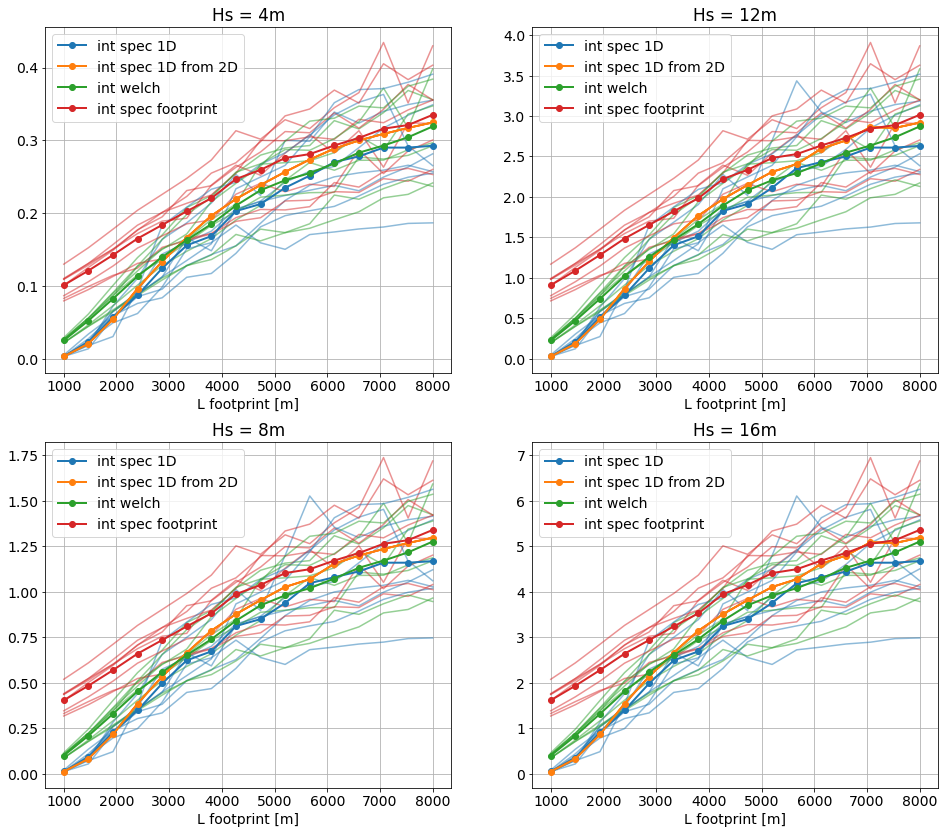

In [25]:
fig,axs = plt.subplots(2,2,figsize=(16,14))
for ihs in range(4):
    for isee in range(nseed):
        if isee==0:
            cl1, =axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5)
            cl2, =axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5)
            cl3, =axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5)
            cl4, =axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5)
        else:
            axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5,color=cl1.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5,color=cl2.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5,color=cl3.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5,color=cl4.get_color())
    
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl1.get_color(),alpha=1,label='int spec 1D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_2D_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl2.get_color(),alpha=1,label='int spec 1D from 2D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_welch[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl3.get_color(),alpha=1,label='int welch')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_footspec[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl4.get_color(),alpha=1,label='int spec footprint')
    axs[ihs%2,ihs//2].legend()
    axs[ihs%2,ihs//2].set_xlabel('L footprint [m]')
    axs[ihs%2,ihs//2].set_title('Hs = '+str(Hss[ihs])+'m')

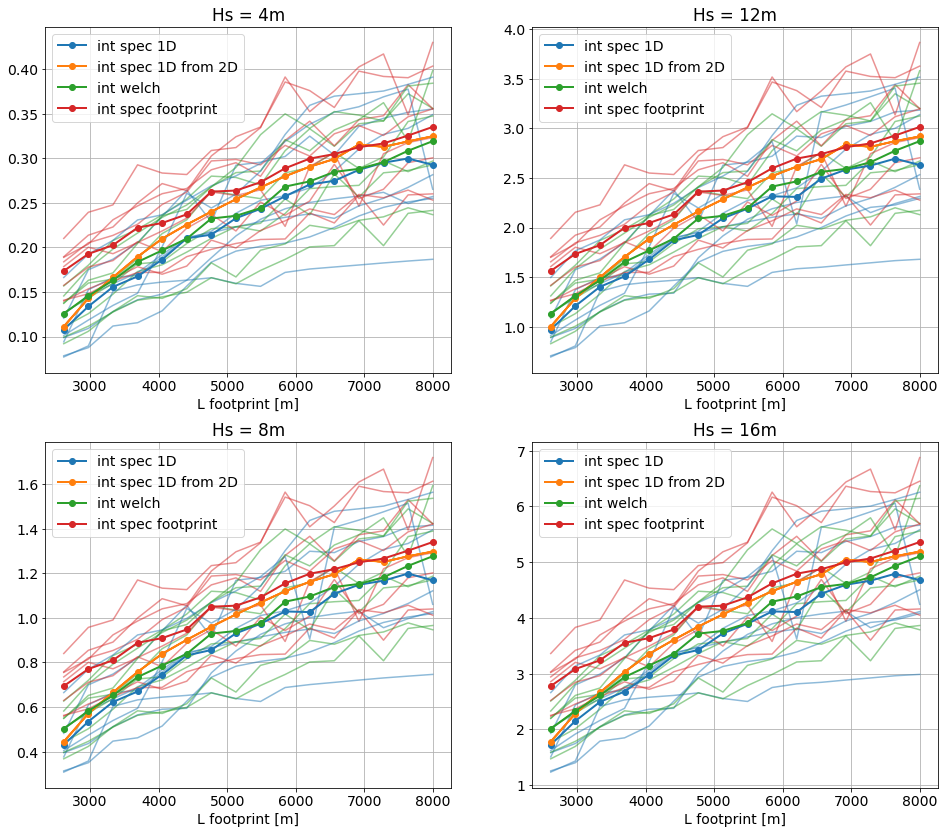

In [111]:
fig,axs = plt.subplots(2,2,figsize=(16,14))
for ihs in range(4):
    for isee in range(nseed):
        if isee==0:
            cl1, =axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5)
            cl2, =axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5)
            cl3, =axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5)
            cl4, =axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5)
        else:
            axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5,color=cl1.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5,color=cl2.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5,color=cl3.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5,color=cl4.get_color())
    
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl1.get_color(),alpha=1,label='int spec 1D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_2D_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl2.get_color(),alpha=1,label='int spec 1D from 2D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_welch[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl3.get_color(),alpha=1,label='int welch')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_footspec[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl4.get_color(),alpha=1,label='int spec footprint')
    axs[ihs%2,ihs//2].legend()
    axs[ihs%2,ihs//2].set_xlabel('L footprint [m]')
    axs[ihs%2,ihs//2].set_title('Hs = '+str(Hss[ihs])+'m')

In [13]:
# nLL = 6
# LLs=np.flip(np.linspace(1000,8000,nLL))
nxA = nx
#     nxtile = int(nxA//Ntiles)
# nLL=20
# LLs=np.flip(np.linspace(500,8000,nLL))
# nxtile = int(LLs.min()//dx)
# Ntiles = int(nx//nxtile)
# Ntiles_overlap = 2*(nx//(LLs.min()//dx))-1

coeff_LL = np.zeros(nLL)
Nts = np.zeros(nLL,dtype=np.int)
for il,LL in enumerate(LLs):
    nxtile = int(LL//dx)
    Ntiles = int(nxA//nxtile)
    shx = int(nxtile//2)
    Ntiles_overlap = 2*Ntiles-1
    Nts[il] = int(Ntiles_overlap)
    coeff_LL[il] = (0.0799*LL+347)/nxtile
    print('Nb of tiles : ',Ntiles_overlap,' , size of tile (pixel) : ',nxtile)

Nb of tiles :  9  , size of tile (pixel) :  800
Nb of tiles :  9  , size of tile (pixel) :  760
Nb of tiles :  9  , size of tile (pixel) :  721
Nb of tiles :  9  , size of tile (pixel) :  681
Nb of tiles :  11  , size of tile (pixel) :  642
Nb of tiles :  11  , size of tile (pixel) :  602
Nb of tiles :  13  , size of tile (pixel) :  563
Nb of tiles :  13  , size of tile (pixel) :  523
Nb of tiles :  15  , size of tile (pixel) :  484
Nb of tiles :  17  , size of tile (pixel) :  444
Nb of tiles :  17  , size of tile (pixel) :  405
Nb of tiles :  21  , size of tile (pixel) :  365
Nb of tiles :  23  , size of tile (pixel) :  326
Nb of tiles :  27  , size of tile (pixel) :  286
Nb of tiles :  31  , size of tile (pixel) :  247
Nb of tiles :  37  , size of tile (pixel) :  207
Nb of tiles :  47  , size of tile (pixel) :  168
Nb of tiles :  61  , size of tile (pixel) :  128
Nb of tiles :  89  , size of tile (pixel) :  89
Nb of tiles :  159  , size of tile (pixel) :  50


In [139]:
sx0s = np.linspace(0.08,0.15,10)
T0s = np.arange(6,18)
limL = np.zeros((len(sx0s),len(T0s)))
limL2 = np.zeros((len(sx0s),len(T0s)))

for isx,sx0 in enumerate(sx0s):
    for it,T0 in enumerate(T0s):
        Lp=9.81/np.pi*T0**2;
        kp=2*np.pi/Lp;
        sx = kp*sx0
        limL[isx,it]=2*np.pi / (3*sx)
        limL2[isx,it]=2*np.pi / (0.5*sx)

ind=np.unravel_index(np.argmax(limL),np.shape(limL))
print(ind)
print(np.min(limL))
print(np.max(limL))
print('-----------------------------------')
print(np.min(limL2))
print(np.max(limL2))
# plt.pcolormesh(sx0s,T0s,limL.T)

(0, 11)
249.809598677039
3760.1548967533463
-----------------------------------
1498.8575920622338
22560.92938052008


In [154]:
print(8192*5)
iss = np.arange(8,13.5,0.25)
for i in iss:
    print((2**i))
    print(int(2**i))

40960
256.0
256
304.4370214406966
304
362.03867196751236
362
430.5389646099018
430
512.0
512
608.8740428813932
608
724.0773439350247
724
861.0779292198037
861
1024.0
1024
1217.7480857627863
1217
1448.1546878700494
1448
1722.1558584396073
1722
2048.0
2048
2435.4961715255727
2435
2896.309375740099
2896
3444.3117168792146
3444
4096.0
4096
4870.992343051145
4870
5792.618751480198
5792
6888.623433758429
6888
8192.0
8192
9741.98468610229
9741
11585.237502960395
11585


In [14]:
# --- compute integrals of interest ------------
int_func_0_kc = np.zeros((nLL,nHs,nseed))
int_func_tot = np.zeros((nLL,nHs,nseed))
int_func_kc_end = np.zeros((nLL,nHs,nseed))
kmin = np.min(kx[kx>0])
for ih,Hs in enumerate(Hss):
    funcs = spec_funcs[ih]
    for isee in range(nseed):
        func_spec = funcs[isee]
        for il,LL in enumerate(LLs):
            kc = 2*np.pi/(LL)
            int_func_0_kc[il,ih,isee] = spint.quad(func_spec,-kc,-kmin)[0]+spint.quad(func_spec,kmin,kc)[0]
            int_func_kc_end[il,ih,isee] = spint.quad(func_spec,kc,kx.max())[0] + spint.quad(func_spec,kx.min(),-kc)[0]
            int_func_tot[il,ih,isee] = spint.quad(func_spec,kx.min(),-kmin)[0]+spint.quad(func_spec,kmin,kx.max())[0]

In [45]:
int_func_0_kc = int_func_0_kc/dkx
int_func_kc_end = int_func_kc_end/dkx
int_func_tot = int_func_tot/dkx

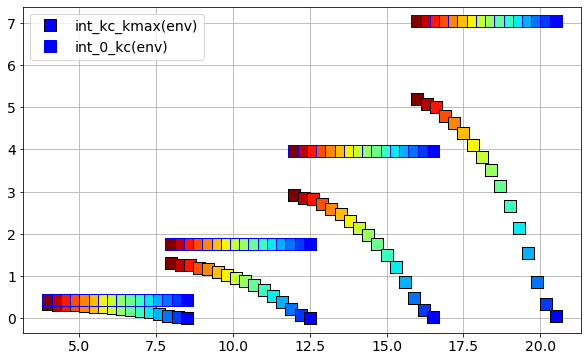

In [46]:
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
#     print(Nts[ill])
    for isee in range(nseed):
        cl3=plt.plot(Hss+0.3*ill,int_func_kc_end[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='k')
        cl4=plt.plot(Hss+0.3*ill,int_func_tot[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='b')
    if ill==nLL-1:
        cl3[0].set_label('int_kc_kmax(env)')
        cl4[0].set_label('int_0_kc(env)')
plt.legend()

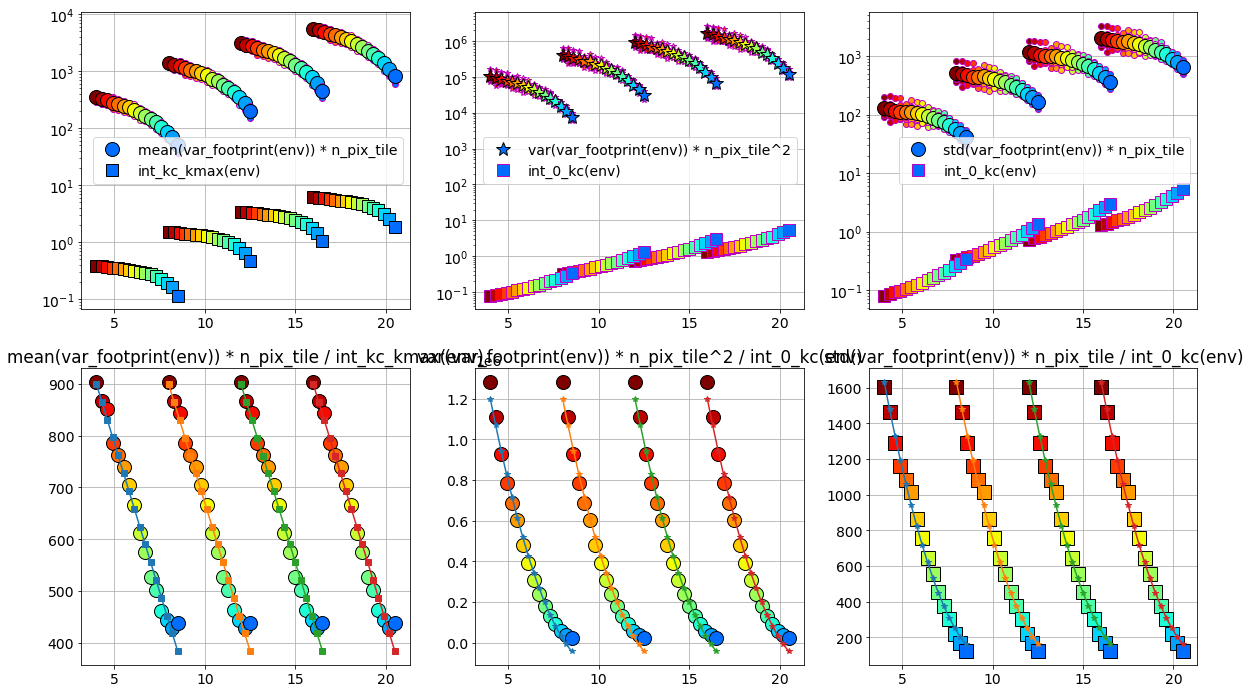

In [33]:
fig,axs=plt.subplots(2,3,figsize=(20,12))

C = np.zeros((nHs,nLL))
D = np.zeros((nHs,nLL))
DD = np.zeros((nHs,nLL))
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
    BB2 = np.zeros((nHs,nseed))
    
#     print(Nts[ill])
    for isee in range(nseed):
#         A0 = env_var_disk_vec[ill,:,isee,:Nts[ill]]
        A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        B = np.sqrt(np.var((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1))
        BB = np.std((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        A2[:,isee]=A
        B2[:,isee]=B
        BB2[:,isee]=BB
#         cl0=axs[0].plot(Hss+0.3*ill,A0,'o',alpha=0.5,color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k')
        _=axs[0,0].plot(Hss+0.3*ill,A*(int(LL//dx)),'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        
        _=axs[0,1].plot(Hss+0.3*ill,B*(int(LL//dx))**2,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        _=axs[0,2].plot(Hss+0.3*ill,BB*(int(LL//dx)),'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
    
    # --- mean over nseed -------------------
    A3=np.mean(A2,axis=1)*(int(LL//dx))
    B3=np.mean(B2,axis=1)*(int(LL//dx))**2
    BB3=np.mean(BB2,axis=1)*(int(LL//dx))
    
    C3 = np.mean(int_func_kc_end[ill,:,:],axis=-1)
    D3 = np.mean(int_func_0_kc[ill,:,:],axis=-1)
    C[:,ill] = A3/C3
    D[:,ill] = B3/D3
    DD[:,ill] = BB3/D3
    
    cl1=axs[0,0].plot(Hss+0.3*ill,A3,'o',color=plt.cm.jet(LL/LLs[0]),
                    markeredgecolor='k',markersize=14,zorder=2)
    cl3=axs[0,0].plot(Hss+0.3*ill,C3,'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='k',zorder=100)
    
    cl2=axs[0,1].plot(Hss+0.3*ill,B3,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl22=axs[0,2].plot(Hss+0.3*ill,BB3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl4=axs[0,1].plot(Hss+0.3*ill,D3,'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='m')
    cl44=axs[0,2].plot(Hss+0.3*ill,D3,'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='m')
    
    cl5=axs[1,0].plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl6=axs[1,1].plot(Hss+0.3*ill,B3/D3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl66=axs[1,2].plot(Hss+0.3*ill,BB3/D3,'s',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    
    if ill==nLL-1:
        cl1[0].set_label('mean(var_footprint(env)) * n_pix_tile')
        cl2[0].set_label('var(var_footprint(env)) * n_pix_tile^2')
        cl22[0].set_label('std(var_footprint(env)) * n_pix_tile')
        cl3[0].set_label('int_kc_kmax(env)')
        cl4[0].set_label('int_0_kc(env)')#' / int_kc_kmax(env)')
        cl44[0].set_label('int_0_kc(env)')#' / int_kc_kmax(env)')
        axs[1,0].set_title('mean(var_footprint(env)) * n_pix_tile / int_kc_kmax(env)')
        axs[1,1].set_title('var(var_footprint(env)) * n_pix_tile^2 / int_0_kc(env)')
        axs[1,2].set_title('std(var_footprint(env)) * n_pix_tile / int_0_kc(env)')
        
axs[0,0].legend()
axs[0,0].set_yscale('log')
axs[0,1].set_yscale('log')
axs[0,2].set_yscale('log')
axs[0,1].legend()
# axs[1,1].legend()
# axs[1,0].legend()
# axs[1,2].legend()
axs[0,2].legend()
# axs[1,1].set_yscale('log')

nxtiles = (LLs//dx)
ntypes=4
slopes = np.zeros((ntypes,nHs))
intercepts = np.zeros((ntypes,nHs))
for ih,Hs in enumerate(Hss):
    res1 = stats.linregress((LLs[:]),C[ih,:])
#     print('A3/C3 =>   Hs = ',Hs,'  : slope = ',res1.slope,' and intercept = ',res1.intercept)
    y1 = res1.slope*(LLs)+res1.intercept
    slopes[0,ih]=res1.slope
    intercepts[0,ih]=res1.intercept
    _=axs[1,0].plot(Hs+0.3*np.arange(nLL),y1,'s-')
        
    res2 = stats.linregress(LLs[:],D[ih,:])
    slopes[1,ih]=res2.slope
    intercepts[1,ih]=res2.intercept
# #     print('B3/D3 =>   Hs = ',Hs,'  : slope = ',res2.slope,' and intercept = ',res2.intercept)
#     y2 = res2.slope*LLs+res2.intercept
#     _=axs[1,1].plot(Hs+0.3*np.arange(nLL),y2,'s-')
    
    res2 = stats.linregress(LLs[:]**2,D[ih,:])
    slopes[2,ih]=res2.slope
    intercepts[2,ih]=res2.intercept
#     print('B3/D3 =>   Hs = ',Hs,'  : slope = ',res2.slope,' and intercept = ',res2.intercept)
    y2 = res2.slope*LLs**2+res2.intercept
    _=axs[1,1].plot(Hs+0.3*np.arange(nLL),y2,'*-')
    
    res22 = stats.linregress(LLs[:]**2,DD[ih,:])
    slopes[3,ih]=res22.slope
    intercepts[3,ih]=res22.intercept
    y22 = res22.slope*LLs**2+res22.intercept
    _=axs[1,2].plot(Hs+0.3*np.arange(nLL),y22,'*-')


# ## ---------- check ---------
# fig,axs=plt.subplots(1,2,figsize=(20,8))
# C = np.zeros((nHs,nLL))
# D = np.zeros((nHs,nLL))
# for ill,LL in enumerate(LLs):
#     A2 = np.zeros((nHs,nseed))
#     B2 = np.zeros((nHs,nseed))
# #     for ill,LL in enumerate(LLs):
#     for isee in range(nseed):
#         A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
#         B = np.std((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
#         A2[:,isee]=A
#         B2[:,isee]=B
#     A30=np.mean(A2,axis=1)
#     A3=np.mean(A2,axis=1)*(int(LL//dx))
#     B3=np.mean(B2,axis=1)*(int(LL//dx))
#     C3 = np.mean(int_func_kc_end[ill,:,:],axis=-1)#/int_func_tot[ill,:,:],axis=-1)#
#     C4 = np.mean(int_func_0_kc[ill,:,:],axis=-1)#/int_func_tot[ill,:,:],axis=-1)#

#     C[:,ill] = A3/C3
#     D[:,ill] = B3/C4
#     _=axs[0].plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
#     _=axs[1].plot(Hss+0.3*ill,B3/C4,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    
#     if ill<len(LLs)-4:
#         _=axs[0].plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m',markersize=14)
# #     res = stats.linregress(np.sqrt(Hs_stds_2[:,ihs]), np.sqrt(Hs2_estimated_std[:,ihs]))
# #     slope[ihs]=res.slope
# #     inter[ihs]=res.intercept
# #     _=plt.plot(LLs+30*ih,A3-C3,'*',color=plt.cm.jet(Hs/Hss[-1]),markeredgecolor='k',markersize=14)
# #     plt.yscale('log')
# for ih,Hs in enumerate(Hss):
#     res = stats.linregress(LLs[:],C[ih,:])
#     print('Hs = ',Hs,'  : slope = ',res.slope,' and intercept = ',res.intercept)
#     y = res.slope*LLs+res.intercept
#     _=axs[0].plot(Hs+0.3*np.arange(nLL),y,'*-')
# #     _=plt.yscale('log')
# #     _=plt.plot(Hss+0.1*ill,np.mean(B2,axis=1),'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)

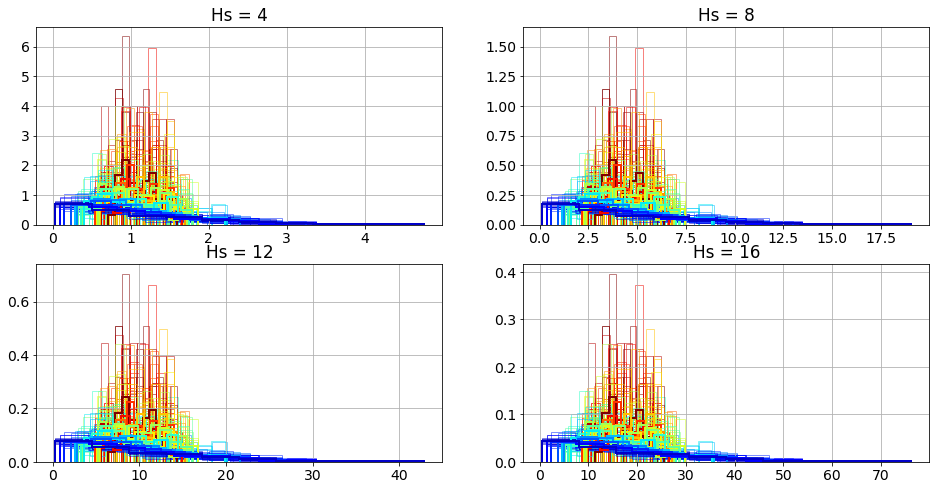

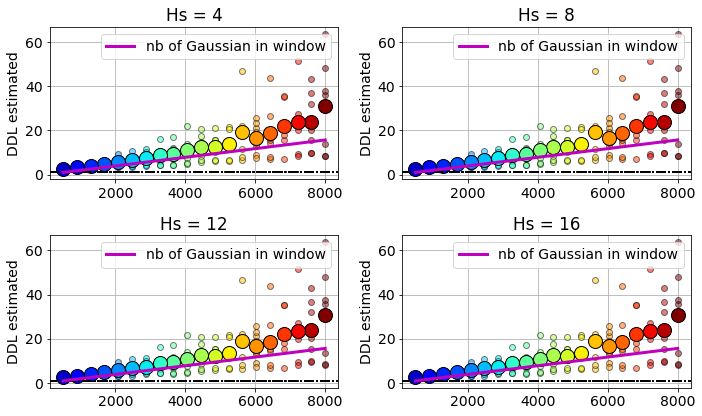

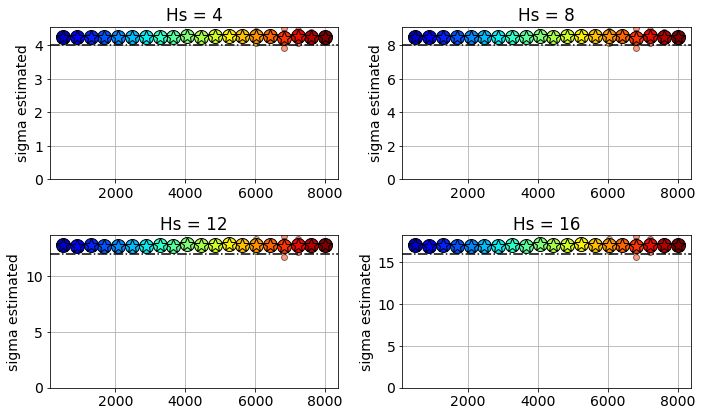

In [62]:
fig,axs=plt.subplots(2,2,figsize=(16,8))

var_chi2 = np.zeros((nHs,nLL,nseed))
mean_chi2 = np.zeros((nHs,nLL,nseed))
ddl_chi2 = np.zeros((nHs,nLL,nseed))
sigma_chi2 = np.zeros((nHs,nLL,nseed))
sigma_norm = np.zeros((nHs,nLL,nseed))
for ih,Hs in enumerate(Hss):
    for ill,LL in enumerate(LLs):
        for isee in range(nseed):
            A = np.squeeze(Hs_footprints_disk_2_vec[ill,ih,isee,:Nts[ill]])#*(LL)/(LL-1)
            var_chi20 = np.var(A)
            mean_chi20 = np.mean(A)
            ddl0 = 2*(mean_chi20**2/var_chi20)
            
            var_chi2[ih,ill,isee] = var_chi20
            mean_chi2[ih,ill,isee] = mean_chi20
            ddl_chi2[ih,ill,isee] = ddl0
            sigma_chi2[ih,ill,isee] = (var_chi20*ddl0/2)**(1/4)#*(ddl0)/(ddl0-1)
            sigma_norm[ih,ill,isee] = (mean_chi20)**(1/2)#*(ddl0)/(ddl0-1)
            
            if isee == 0:
                nA,bins,_=axs[ih//2,ih%2].hist(A,density=True,histtype='step',
                                              color=plt.cm.jet(LL/LLs[0]),alpha=0.5,zorder=0)
            else:
                nA0,bins,_=axs[ih//2,ih%2].hist(A,bins=bins,density=True,histtype='step',
                                              color=plt.cm.jet(LL/LLs[0]),alpha=0.5,zorder=1)
                nA = nA + nA0
            
        _=axs[ih//2,ih%2].hist(bins[:-1],bins,weights=nA/nseed,histtype='step',
                                              color=plt.cm.jet(LL/LLs[0]),linewidth=2,zorder=10)
    axs[ih//2,ih%2].set_title('Hs = '+str(Hs))    

sz_gaussienne_r = 1/sx
nb_ddl_gaussienne = LLs/sz_gaussienne_r

fig,axs=plt.subplots(2,2)

for ih,Hs in enumerate(Hss):
    for ill,LL in enumerate(LLs):
        for isee in range(nseed):   
            A = ddl_chi2[ih,ill,isee]
            _=axs[ih//2,ih%2].plot(LL,A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',alpha=0.5)
        _=axs[ih//2,ih%2].plot(LL,np.mean(ddl_chi2[ih,ill,:],axis=-1),'o',color=plt.cm.jet(LL/LLs[0]),
                   markeredgecolor='k',markersize=14)
        _=axs[ih//2,ih%2].set_ylabel('DDL estimated')
        _=axs[ih//2,ih%2].axhline(1,color='k',linestyle='-.')
#         _=plt.axhline
    _=axs[ih//2,ih%2].plot(LLs,nb_ddl_gaussienne,color='m',linestyle='-',linewidth=3,label='nb of Gaussian in window')
    axs[ih//2,ih%2].set_title('Hs = '+str(Hs))
    _=axs[ih//2,ih%2].legend()
plt.tight_layout()

fig,axs=plt.subplots(2,2)

for ih,Hs in enumerate(Hss):
    for ill,LL in enumerate(LLs):
        for isee in range(nseed):   
            A = sigma_norm[ih,ill,isee]
            _=axs[ih//2,ih%2].plot(LL,4*A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',alpha=0.5)
        _=axs[ih//2,ih%2].plot(LL,np.mean(4*sigma_norm[ih,ill,:],axis=-1),'o',color=plt.cm.jet(LL/LLs[0]),
                   markeredgecolor='k',markersize=14)
        _=axs[ih//2,ih%2].plot(LL,np.mean(4*sigma_chi2[ih,ill,:],axis=-1),'*',color=plt.cm.jet(LL/LLs[0]),
                   markeredgecolor='k',markersize=14)
        _=axs[ih//2,ih%2].set_ylabel('sigma estimated')
    _=axs[ih//2,ih%2].axhline(Hs,color='k',linestyle='-.')

    axs[ih//2,ih%2].set_title('Hs = '+str(Hs)) 
    axs[ih//2,ih%2].set_ylim((0,None))
plt.tight_layout()
#             A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
#             B = np.sqrt(np.var((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1))

In [37]:
np.sqrt(13)

3.605551275463989

In [ ]:
np.sqrt()

Hs =  4   : slope =  0.07995857904991009  and intercept =  347.1526216214478
Hs =  8   : slope =  0.07995534629866351  and intercept =  347.1771633497528
Hs =  12   : slope =  0.07995795919609124  and intercept =  347.1661501443251
Hs =  16   : slope =  0.0799517229802867  and intercept =  347.1831293240812


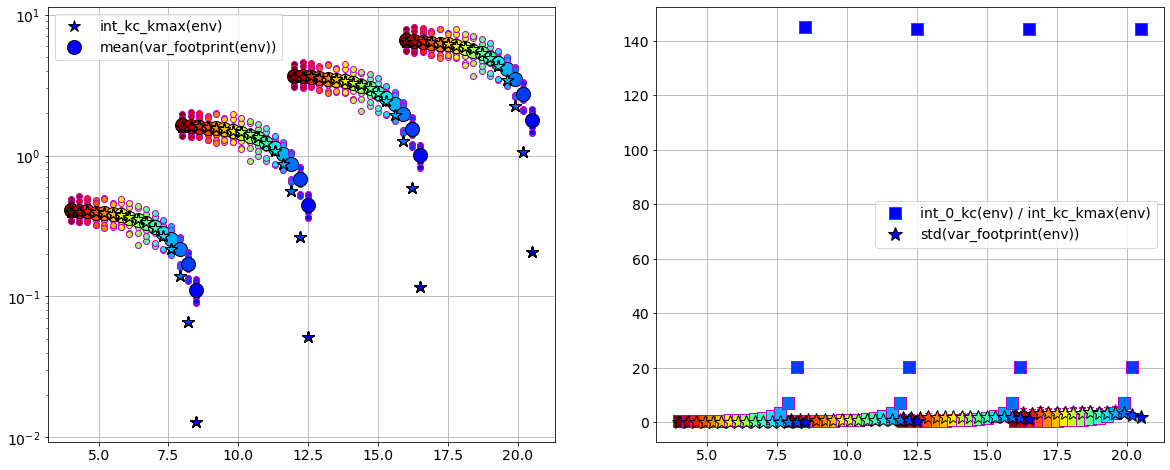

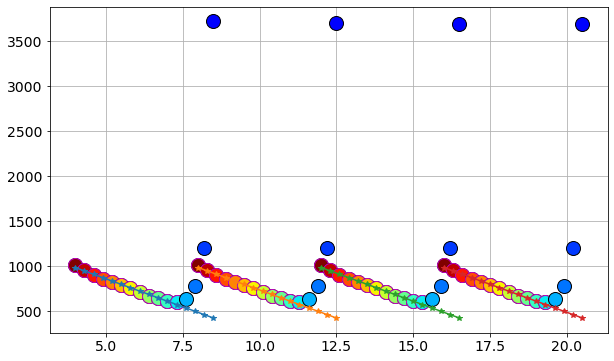

In [93]:
fig,axs=plt.subplots(1,2,figsize=(20,8))
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
#     print(Nts[ill])
    for isee in range(nseed):
        A0 = env_var_disk_vec[ill,:,isee,:Nts[ill]]
        A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        B = np.std((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        A2[:,isee]=A
        B2[:,isee]=B
#         cl0=axs[0].plot(Hss+0.3*ill,A0,'o',alpha=0.5,color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k')
        cl1=axs[0].plot(Hss+0.3*ill,A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        cl3=axs[0].plot(Hss+0.3*ill,int_func_kc_end[ill,:,isee]*(0.0799*LL+347)/(int(LL//dx)),'*',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='k',zorder=100)
        
        cl2=axs[1].plot(Hss+0.3*ill,B,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        cl4=axs[1].plot(Hss+0.3*ill,int_func_0_kc[ill,:,isee]/int_func_kc_end[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),
                     markersize=12,markeredgecolor='m')
#         cl4=plt.plot(Hss+0.3*ill,int_func_tot[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),
#                      markersize=12,markeredgecolor='b')
    cl1=axs[0].plot(Hss+0.3*ill,np.mean(A2,axis=1),'o',color=plt.cm.jet(LL/LLs[0]),
                    markeredgecolor='k',markersize=14,zorder=2)
    cl2=axs[1].plot(Hss+0.3*ill,np.mean(B2,axis=1),'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    if ill==nLL-1:
        cl1[0].set_label('mean(var_footprint(env))')
        cl2[0].set_label('std(var_footprint(env))')
        cl3[0].set_label('int_kc_kmax(env)')
        cl4[0].set_label('int_0_kc(env) / int_kc_kmax(env)')
axs[0].legend()
axs[0].set_yscale('log')
axs[1].legend()
       
plt.figure()
C = np.zeros((nHs,nLL))
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
#     for ill,LL in enumerate(LLs):
    for isee in range(nseed):
        A = np.mean((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        B = np.std((env_var_disk_vec[ill,:,isee,:Nts[ill]]),axis=-1)
        A2[:,isee]=A
        B2[:,isee]=B
#         _=plt.plot(Hss+0.1*ill,A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
#         _=plt.plot(Hss+0.1*ill,B,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
#         _=plt.plot(Hss+0.1*ill,var_env_2D_above[ill,:,isee],'s',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k')
    A30=np.mean(A2,axis=1)
    A3=np.mean(A2,axis=1)*(int(LL//dx))
    B3=np.mean(B2,axis=1)
    C3 = np.mean(int_func_kc_end[ill,:,:],axis=-1)#/int_func_tot[ill,:,:],axis=-1)#
    C[:,ill] = A3/C3
    _=plt.plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    if ill<len(LLs)-4:
        _=plt.plot(Hss+0.3*ill,A3/C3,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m',markersize=14)
#     res = stats.linregress(np.sqrt(Hs_stds_2[:,ihs]), np.sqrt(Hs2_estimated_std[:,ihs]))
#     slope[ihs]=res.slope
#     inter[ihs]=res.intercept
#     _=plt.plot(LLs+30*ih,A3-C3,'*',color=plt.cm.jet(Hs/Hss[-1]),markeredgecolor='k',markersize=14)
#     plt.yscale('log')
for ih,Hs in enumerate(Hss):
    res = stats.linregress(LLs[:-4],C[ih,:-4])
    print('Hs = ',Hs,'  : slope = ',res.slope,' and intercept = ',res.intercept)
    y = res.slope*LLs+res.intercept
    _=plt.plot(Hs+0.3*np.arange(nLL),y,'*-')
#     _=plt.yscale('log')
#     _=plt.plot(Hss+0.1*ill,np.mean(B2,axis=1),'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)

In [109]:
print('1/dkx = ',1/dkx)
print('dkx = ',dkx)
print('dx = ',dx)
print('Lp = ',Lp)
print('kp = ',kp)
print('sx = ',sx)#0.0799)

1/dkx =  6442.592096359485
dkx =  0.00015521702833942721
dx =  10
Lp =  449.6572776186701
kp =  0.01397327613700498
sx =  0.017488455740932392


In [53]:
plt.figure()
for ill,LL in enumerate(LLs):
    A2 = np.zeros((nHs,nseed))
    B2 = np.zeros((nHs,nseed))
    for isee in range(nseed):
        A = np.std(np.sqrt(np.squeeze(Hs_footprints_disk_2_vec[ill,:,isee,:Nts[ill]])),axis=-1)
        B0 = 2*np.sqrt(8*(env_means_disk_vec[ill,:,isee,:Nts[ill]]**2+env_var_disk_vec[ill,:,isee,:Nts[ill]]))
        B = np.std(B0,axis=-1)
        A2[:,isee]=A
        B2[:,isee]=B
#         C0 = 
#         C1 = 
#         C = 8*(C0 + C1)
        _=plt.plot(Hss+0.3*ill,A,'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')
        _=plt.plot(Hss+0.3*ill,B,'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='m')      
        
    cl=plt.plot(Hss+0.3*ill,np.mean(A2,axis=1),'o',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14)
    cl2=plt.plot(Hss+0.3*ill,np.mean(B2,axis=1),'*',color=plt.cm.jet(LL/LLs[0]),markeredgecolor='k',markersize=14) 
    if ill==nLL-1:
        cl[0].set_label('std(Hs_footprint)')
        cl2[0].set_label('std(2*sqrt(8*(<env>^2 + <env^2>)))')
_=plt.legend()
# Hs_footprints_disk_2_vec
# env_means_disk_vec
# env_var_disk_vec

AttributeError: 'Figure' object has no property 'figsze'

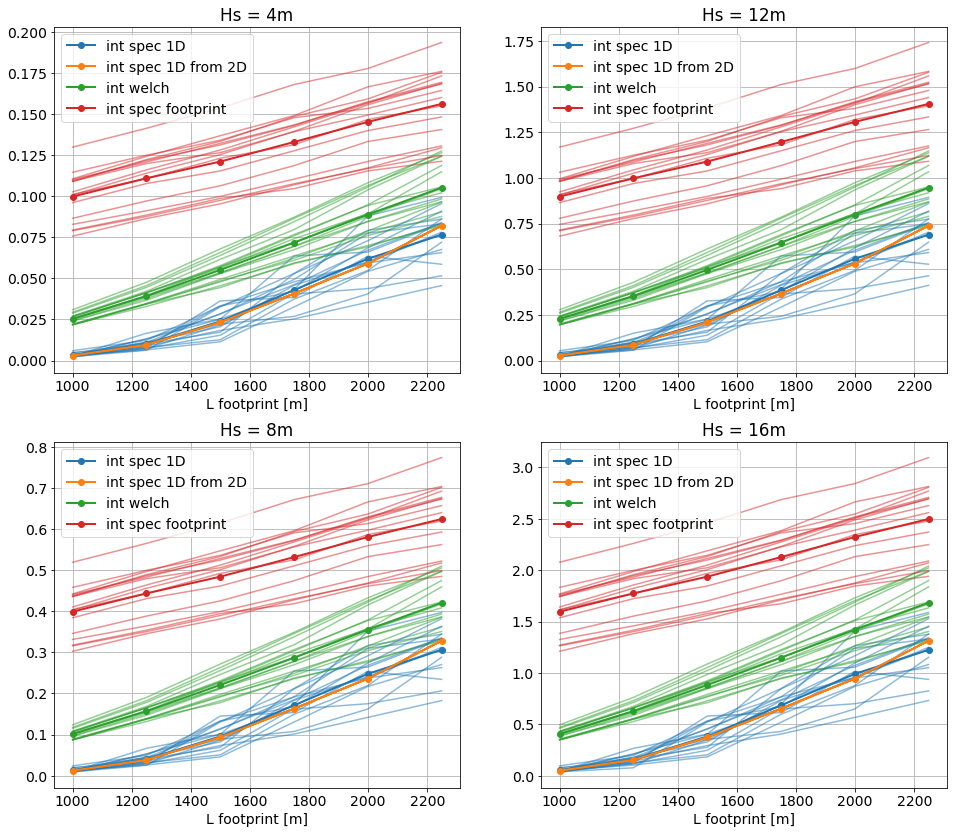

In [119]:
# OLD 
fig,axs = plt.subplots(2,2,figsize=(16,14))
for ihs in range(4):
    for isee in range(nseed):
        if isee==0:
            cl1, =axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5)
            cl2, =axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5)
            cl3, =axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5)
            cl4, =axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5)
        else:
            axs[ihs%2,ihs//2].plot(LLs,var_env_above[:,ihs,isee],'-',alpha=0.5,color=cl1.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_2D_above[:,ihs,isee],'-',alpha=0.5,color=cl2.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_welch[:,ihs,isee],'-',alpha=0.5,color=cl3.get_color())
            axs[ihs%2,ihs//2].plot(LLs,var_env_footspec[:,ihs,isee],'-',alpha=0.5,color=cl4.get_color())
    
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl1.get_color(),alpha=1,label='int spec 1D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_2D_above[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl2.get_color(),alpha=1,label='int spec 1D from 2D')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_welch[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl3.get_color(),alpha=1,label='int welch')
    axs[ihs%2,ihs//2].plot(LLs,np.mean(var_env_footspec[:,ihs,:],axis=-1),'o-',
                           linewidth=2,color=cl4.get_color(),alpha=1,label='int spec footprint')
    axs[ihs%2,ihs//2].legend()
    axs[ihs%2,ihs//2].set_xlabel('L footprint [m]')
    axs[ihs%2,ihs//2].set_title('Hs = '+str(Hss[ihs])+'m')

In [ ]:
print('dkx spec = ',dkxspec)
print('dkx welch = ',(freq_welch[1]-freq_welch[0]))
print(kx)
print(freq_welch)
print(freq_footprint_mkmax_kmax[freq_footprint_mkmax_kmax>=0])



In [16]:
np.fft.fftfreq(Ntiles, d=dx)*2*np.pi

array([ 0.        ,  0.0079534 ,  0.0159068 ,  0.0238602 ,  0.0318136 ,
        0.039767  ,  0.04772039,  0.05567379,  0.06362719,  0.07158059,
        0.07953399,  0.08748739,  0.09544079,  0.10339419,  0.11134759,
        0.11930099,  0.12725439,  0.13520779,  0.14316118,  0.15111458,
        0.15906798,  0.16702138,  0.17497478,  0.18292818,  0.19088158,
        0.19883498,  0.20678838,  0.21474178,  0.22269518,  0.23064857,
        0.23860197,  0.24655537,  0.25450877,  0.26246217,  0.27041557,
        0.27836897,  0.28632237,  0.29427577,  0.30222917,  0.31018257,
       -0.31018257, -0.30222917, -0.29427577, -0.28632237, -0.27836897,
       -0.27041557, -0.26246217, -0.25450877, -0.24655537, -0.23860197,
       -0.23064857, -0.22269518, -0.21474178, -0.20678838, -0.19883498,
       -0.19088158, -0.18292818, -0.17497478, -0.16702138, -0.15906798,
       -0.15111458, -0.14316118, -0.13520779, -0.12725439, -0.11930099,
       -0.11134759, -0.10339419, -0.09544079, -0.08748739, -0.07

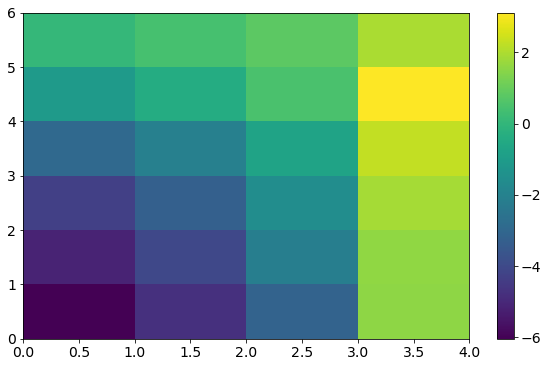

In [42]:
im=plt.pcolormesh(mean_sum_spec_env_without0-var_env_above)


plt.colorbar(im)
print()

In [43]:
mean_sum_spec_env_without0

array([[0.38494337, 1.65761406, 3.24821988, 7.97773969],
       [0.37636705, 1.50950758, 3.4014125 , 7.15898989],
       [0.3629275 , 1.40706787, 3.07209237, 6.57059241],
       [0.3301595 , 1.18203026, 2.52253352, 5.54522246],
       [0.26472685, 0.92433046, 1.81858147, 4.44832908],
       [0.13148376, 0.46924725, 0.8856989 , 2.02864271]])

In [45]:
var_env2_above

array([[1446.03962912, 1446.03962912, 1446.03962912, 1446.03962912],
       [1255.4789931 , 1255.4789931 , 1255.4789931 , 1255.4789931 ],
       [1027.13625274, 1027.13625274, 1027.13625274, 1027.13625274],
       [ 704.64401486,  704.64401486,  704.64401486,  704.64401486],
       [ 257.76175413,  257.76175413,  257.76175413,  257.76175413],
       [   3.38289519,    3.38289519,    3.38289519,    3.38289519]])

In [44]:
var_env_above

array([[6.42187206, 6.42187206, 6.42187206, 6.42187206],
       [5.55476987, 5.55476987, 5.55476987, 5.55476987],
       [4.67615213, 4.67615213, 4.67615213, 4.67615213],
       [3.26957055, 3.26957055, 3.26957055, 3.26957055],
       [1.33705633, 1.33705633, 1.33705633, 1.33705633],
       [0.06831445, 0.06831445, 0.06831445, 0.06831445]])

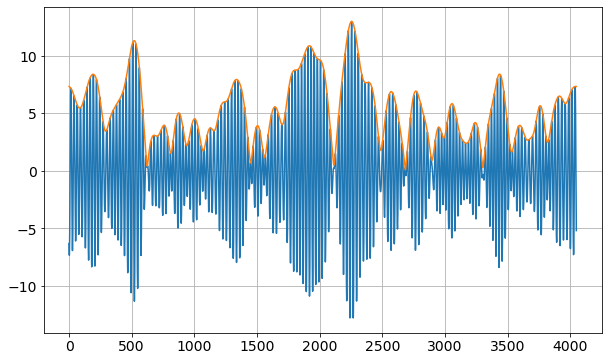

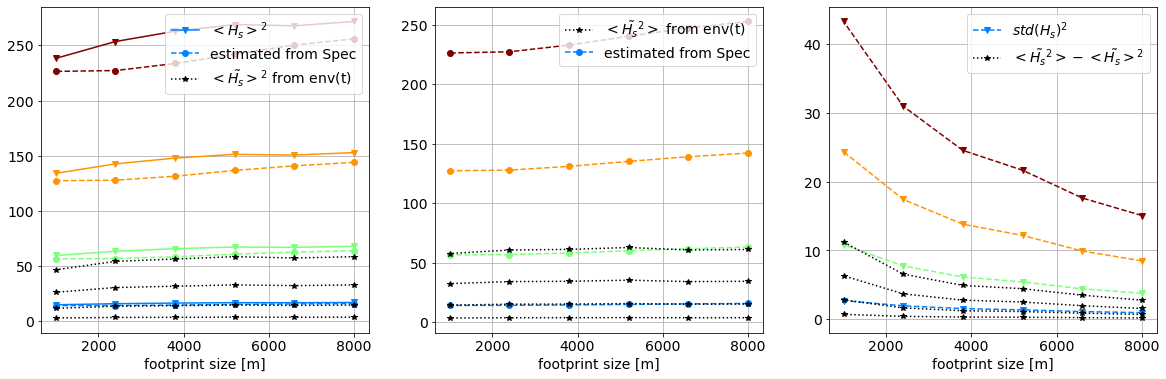

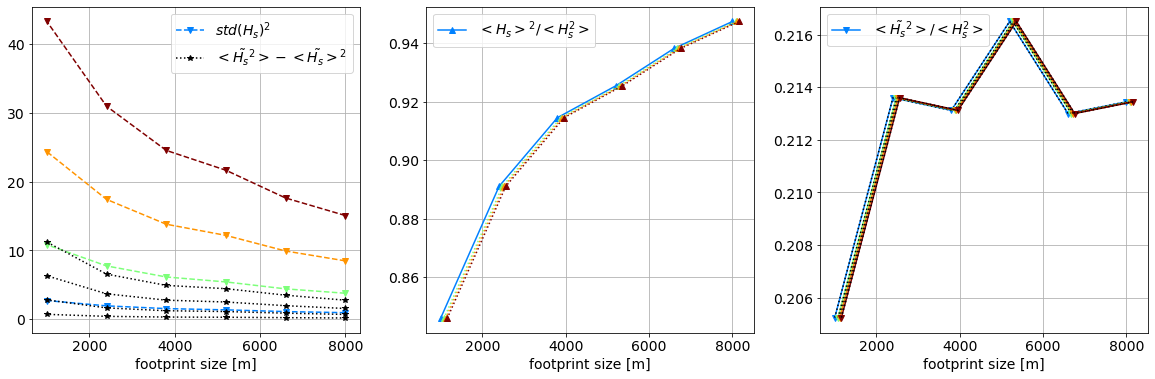

In [73]:
_=plt.figure()
_=plt.plot(S1D_r,'-')
_=plt.plot(np.sqrt(S1D_r**2+S1D_i**2),'-')
_=plt.grid(True)

# _=plt.figure()
# for ihs,Hs in enumerate(Hss):
#     if ihs==0:
#         _=plt.plot(LLs,Hs2_means[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s^2>$')
#         _=plt.plot(LLs,Hs_means_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s>^2$')
#         _=plt.plot(LLs,Hs2_estimated_mean[:,ihs],'*:k',label=r'$<\tilde{H_s}^2>$ from env(t)')#,color=plt.cm.jet(Hs/Hss[-1]),label=r'$<\tilde{H_s}^2>$ from env(t)')
#     else:
#         _=plt.plot(LLs,Hs2_means[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]))
#         _=plt.plot(LLs,Hs_means_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]))
#         _=plt.plot(LLs,Hs2_estimated_mean[:,ihs],'*:k')#,color=plt.cm.jet(Hs/Hss[-1]))
# _=plt.legend()

fig,axs=plt.subplots(1,3,figsize=(20,6))
for ihs,Hs in enumerate(Hss):
    if ihs==0:
        
        _=axs[0].plot(LLs,Hs_means_2[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s>^2$')
        _=axs[0].plot(LLs,(Hs2_estimated_env[:,ihs]),'o--',color=plt.cm.jet(Hs/Hss[-1]),label='estimated from Spec')
        _=axs[0].plot(LLs,Hs_estimated_mean[:,ihs]**2,'*:k',label=r'$<\tilde{H_s}>^2$ from env(t)',zorder=100)
#         _=axs[1].plot(LLs,Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s^2>$')
        _=axs[1].plot(LLs,Hs2_estimated_mean[:,ihs],'*:k',label=r'$<\tilde{H_s}^2>$ from env(t)',zorder=100)
        _=axs[1].plot(LLs,(Hs2_estimated_env2[:,ihs]),'o--',color=plt.cm.jet(Hs/Hss[-1]),label='estimated from Spec')
        _=axs[2].plot(LLs,Hs_stds_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]),label=r'$std(H_s)^2$')
        _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]-Hs_estimated_mean[:,ihs]**2,'*:k',label=r'$<\tilde{H_s}^2>-<\tilde{H_s}>^2$')    
#         _=axs[1].plot(LLs,Hs_means_2[:,ihs]/Hs2_means[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s>^2/<H_s^2>$')
#         _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<\tilde{H_s}^2>/<H_s^2>$')
#         _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],':k')
    else:
        
        _=axs[0].plot(LLs,Hs_means_2[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[0].plot(LLs,(Hs2_estimated_env[:,ihs]),'o--',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[0].plot(LLs,Hs_estimated_mean[:,ihs]**2,'*:k',zorder=100)
#         _=axs[1].plot(LLs,Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[1].plot(LLs,Hs2_estimated_mean[:,ihs],'*:k',zorder=100)
        _=axs[1].plot(LLs,(Hs2_estimated_env2[:,ihs]),'o--',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[2].plot(LLs,Hs_stds_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]-Hs_estimated_mean[:,ihs]**2,'*:k')
#         _=axs[1].plot(LLs+Hs*10,Hs_means_2[:,ihs]/Hs2_means[:,ihs],'^:',color=plt.cm.jet(Hs/Hss[-1]))
#         _=axs[2].plot(LLs+Hs*10,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]))
#         _=axs[2].plot(LLs+Hs*10,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],':k')#,color=plt.cm.jet(Hs/Hss[-1]))
_=axs[0].legend()
_=axs[1].legend()
_=axs[2].legend()
_=axs[0].set_xlabel('footprint size [m]')
_=axs[1].set_xlabel('footprint size [m]')
_=axs[2].set_xlabel('footprint size [m]')

fig,axs=plt.subplots(1,3,figsize=(20,6))
for ihs,Hs in enumerate(Hss):
    if ihs==0:
        #_=axs[0].plot(LLs,Hs2_stds[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$std(H_s^2)$')
        _=axs[0].plot(LLs,Hs_stds_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]),label=r'$std(H_s)^2$')
        _=axs[0].plot(LLs,Hs2_estimated_mean[:,ihs]-Hs_estimated_mean[:,ihs]**2,'*:k',label=r'$<\tilde{H_s}^2>-<\tilde{H_s}>^2$')
#         _=axs[0].plot(LLs,Hs2_estimated_std[:,ihs],'*:k',label=r'$std(\tilde{H_s}^2)$ from env(t)')
        _=axs[1].plot(LLs,Hs_means_2[:,ihs]/Hs2_means[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<H_s>^2/<H_s^2>$')
        _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]),label=r'$<\tilde{H_s}^2>/<H_s^2>$')
        _=axs[2].plot(LLs,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],':k')
    else:
        #_=axs[0].plot(LLs,Hs2_stds[:,ihs],'^-',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[0].plot(LLs,Hs_stds_2[:,ihs],'v--',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[0].plot(LLs,Hs2_estimated_mean[:,ihs]-Hs_estimated_mean[:,ihs]**2,'*:k')
#         _=axs[0].plot(LLs,Hs2_estimated_std[:,ihs],'*:k')
        _=axs[1].plot(LLs+Hs*10,Hs_means_2[:,ihs]/Hs2_means[:,ihs],'^:',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[2].plot(LLs+Hs*10,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],'v-',color=plt.cm.jet(Hs/Hss[-1]))
        _=axs[2].plot(LLs+Hs*10,Hs2_estimated_mean[:,ihs]/Hs2_means[:,ihs],':k')#,color=plt.cm.jet(Hs/Hss[-1]))
_=axs[0].legend()
_=axs[1].legend()
_=axs[2].legend()
_=axs[0].set_xlabel('footprint size [m]')
_=axs[1].set_xlabel('footprint size [m]')
_=axs[2].set_xlabel('footprint size [m]')

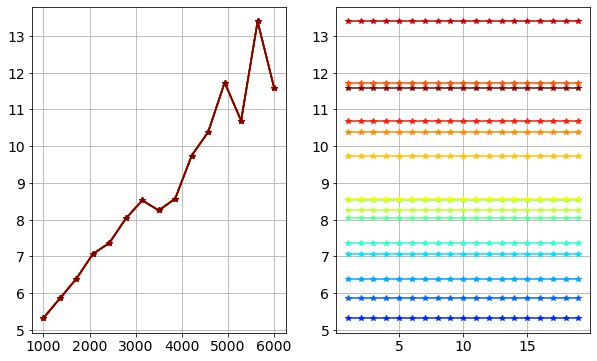

In [72]:
# A=Hs2_estimated_std/Hs2_estimated_mean
A=Hs2_stds/Hs_stds_2
fig,axs=plt.subplots(1,2)
for ihs,Hs in enumerate(Hss):
    axs[0].plot(LLs,A[:,ihs],'*-',color=plt.cm.jet(Hs/Hss[-1]))

for iLL,LL in enumerate(LLs):
    axs[1].plot(Hss,A[iLL,:],'*-',color=plt.cm.jet(LL/LLs[-1]))

Text(0, 0.5, 'slope Hs2_estimated_std/Hs_stds_2')

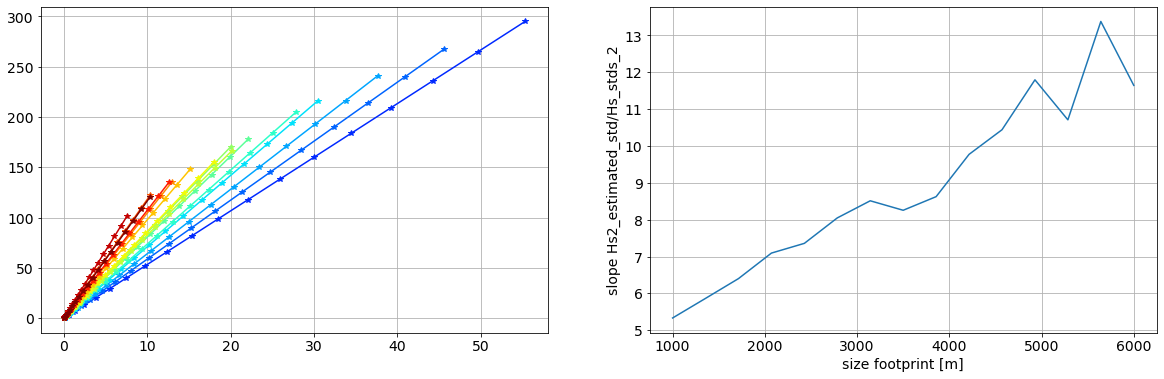

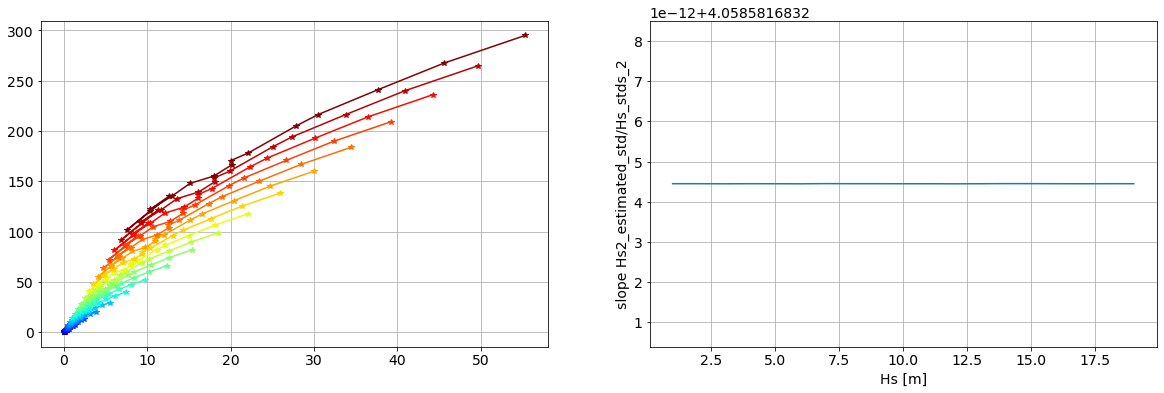

In [9]:
fig,axs=plt.subplots(1,2,figsize=(20,6))
slopell = np.zeros(nLL)
for iLL,LL in enumerate(LLs):
    axs[0].plot(Hs_stds_2[iLL,:],Hs2_estimated_std[iLL,:],'-*',color=plt.cm.jet(LL/LLs[-1]))
    res = stats.linregress(Hs_stds_2[iLL,:],Hs2_estimated_std[iLL,:])
    slopell[iLL]=res.slope
# _=plt.scatter(Hs_stds_2,Hs2_estimated_std,s=np.tile(Hss,(nLL,1))*5,c=np.tile(LLs,(1,nHs)))
# _=plt.plot(Hss,Hs_stds_2.T,'*',label='Hs std 2')
# _=plt.plot(Hss,Hs2_estimated_std.T,'-k',label='Hs2 estimated std')
# _=plt.plot(Hss,Hss*1.05,'--r',label='Hs def*1.05')

axs[1].plot(LLs,slopell)
axs[1].set_xlabel('size footprint [m]')
axs[1].set_ylabel('slope Hs2_estimated_std/Hs_stds_2')

fig,axs=plt.subplots(1,2,figsize=(20,6))
slopehs = np.zeros(nHs)
for ihs,Hs in enumerate(Hss):
    axs[0].plot(Hs_stds_2[:,ihs],Hs2_estimated_std[:,ihs],'-*',color=plt.cm.jet(Hs/Hss[-1]))
    res = stats.linregress(Hs_stds_2[:,ihs],Hs2_estimated_std[:,ihs])
    slopehs[ihs]=res.slope
#     print(res)
# _=plt.scatter(Hs_stds_2,Hs2_estimated_std,s=np.tile(Hss,(nLL,1))*5,c=np.tile(LLs,(1,nHs)))
# _=plt.plot(Hss,Hs_stds_2.T,'*',label='Hs std 2')
# _=plt.plot(Hss,Hs2_estimated_std.T,'-k',label='Hs2 estimated std')
# _=plt.plot(Hss,Hss*1.05,'--r',label='Hs def*1.05')

axs[1].plot(Hss,slopehs)
axs[1].set_xlabel('Hs [m]')
axs[1].set_ylabel('slope Hs2_estimated_std/Hs_stds_2')
# _=plt.yscale('log')
# _=plt.xscale('log')
# _=plt.legend()

ValueError: too many values to unpack (expected 4)

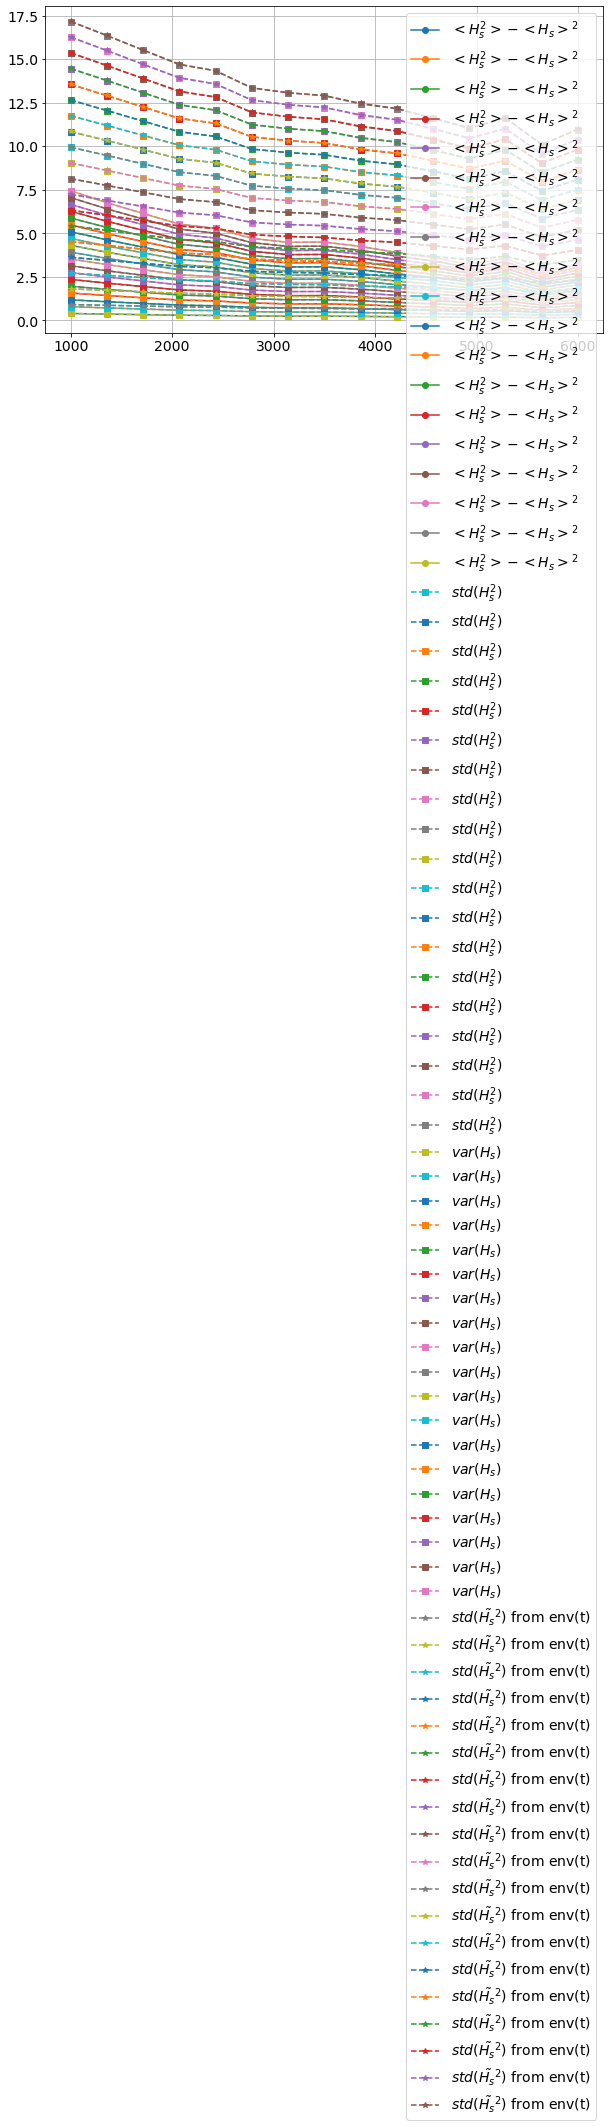

In [10]:
_=plt.figure()
_=plt.plot(LLs,np.sqrt(Hs2_means-Hs_means_2),'o-',label=r'$<H_s^2>-<H_s>^2$')
_=plt.plot(LLs,np.sqrt(Hs2_stds),'s--',label=r'$std(H_s^2)$')
_=plt.plot(LLs,np.sqrt(Hs_stds_2),'s--',label=r'$var(H_s)$')
_=plt.plot(LLs,np.sqrt(Hs2_estimated_std),'*--',label=r'$std(\tilde{H_s}^2)$ from env(t)')
_=plt.legend()

res = stats.linregress(np.sqrt(Hs_stds_2), np.sqrt(Hs2_estimated_std))
print(res)

In [21]:
strs = ['2020-01-01','2020-01-01 00:30:00','2020-01-01 01:00:00','2020-01-01 01:30:00']
import pandas as pd
d={'dates': strs, 'col0': np.arange(0,len(strs))}
A=pd.DataFrame(data=d)
# print(A)

print(A.loc[A['dates']=='2020-01-01 01:00:00'])



                 dates  col0
2  2020-01-01 01:00:00     2


In [7]:
# investigate integration over total signal #############################
isplot=0

### Get a equivalent 2D spectrum from DFT of the surface ################
# -- to verify the coefficients ------------------------------------
Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

### 1D spectrum from integration over ky 
Z1D_def = (np.sum(Z2D_def,axis=0))*dky
Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

### Generate a 1D surface based on 1D spectrum (1 realisation) #########
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(nx))
# -- from original 1D spectrum (from 2D)
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

### Envelope squared A2D and envelope B2D ###############################################
# -- 2D env
A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
B2D = np.sqrt(A2D) 
A2D = A2D-np.mean(A2D.flatten())
B2D = B2D-np.mean(B2D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
Spec_env1_2D = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

# integration over y <=> integration over realisations 
Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky

Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky

Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)
Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D)


# -- 1D env
A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
B1D = np.sqrt(A1D) 
A1D = A1D-np.mean(A1D.flatten())
# B1D = B1D-np.mean(B1D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_from_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/(dkx)
Spec_env1_from_1D = np.abs(np.fft.fft(B1D-np.mean(B1D.flatten()),norm='forward'))**2/(dkx)
Spec_env1_from_1D_notnormal = np.abs(np.fft.fft(B1D,norm='forward'))**2/(dkx) 
Spec_env2_from_1D_shifted = np.fft.fftshift(Spec_env2_from_1D)
Spec_env1_from_1D_shifted = np.fft.fftshift(Spec_env1_from_1D)

Spec_env1_func = spi.interp1d(kx,Spec_env1_from_1D_shifted)
Spec_env2_func = spi.interp1d(kx,Spec_env2_from_1D_shifted)
Spec_env1_from2D_func = spi.interp1d(kx,Spec_env1_from_2D_shifted)

###  Convolution following Rice pp 131-133.
#conv_1D = np.convolve(Z1D_def_noshift,Z1D_def_noshift,'full')*dkx
#conv_1D_pm = conv_1D[nx//2:nx//2+nx]
conv_1D  = myconv(Z1D_def_noshift ,Z1D_def_noshift )*dkx

# This one is the definition we need: convolution with flipped single-sided spectrum
conv_1Da  = 4*myconv(Z1D_def_noshift ,np.flip(Z1D_def_noshift) )*dkx
# conv_1Db  = 8*myconv(Z1D_from_FFT_noshift ,Z1D_from_FFT_noshift )*dkx

conv_1D_shift  = np.fft.fftshift(conv_1D )
conv_1Da_shift = np.fft.fftshift(conv_1Da )
conv_1Da_func = spi.interp1d(kx,conv_1Da_shift)

# conv_1Db_shift = np.fft.fftshift(conv_1Db )

### Check values of Hs from spectrum #####################################
# -- original 2D spectrum
sumZ2D_def=4*np.sqrt(sum(Z2D_def.flatten()*dkx*dky))
# -- reconstructed (DFT) 2D spectrum
sumZ2D_from_FFT=4*np.sqrt(sum(Z2D_from_FFT.flatten()*dkx*dky))
# -- 1D spectrum integrated from original 2D spectrum
sumZ1D_def = 4*np.sqrt(sum(Z1D_def*dkx))


if isprints:
    ##### Prints #####################################################################
    print('---- Hs estimates from spectrum : ----------------------------------')
    print('4*sqrt(Z2D_ref*dkx*dky) = ',sumZ2D_def)
    print('4*sqrt(Z2D_from_FFT*dkx*dky) = ',sumZ2D_from_FFT)
    print('4*sqrt(Z1D_ref*dkx) = ',sumZ1D_def)

### Envelope stds #####################################
A1Dstd = np.std(A1D.flatten())
B1Dstd = np.std(B1D.flatten())
sum_conv1Da   = 4*np.sqrt(sum(conv_1Da_shift*dkx))
# sum_conv1Db   = 4*np.sqrt(sum(conv_1Db_shift*dkx))
sum_Specenv2_1Db = 4*np.sqrt(sum(Spec_env2_from_1D*dkx))
sum_Specenv1_1Db = 4*np.sqrt(sum(Spec_env1_from_1D*dkx))

estim_Hs_from_env = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)#np.sum(Spec_env1_from_1D)*dkx)
estim_Hs_from_env_bis = np.sqrt(8)*np.sqrt(np.sum(Spec_env1_from_1D_notnormal)*dkx)

equiv_Hs_from_env = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
if isprints:
#     print('---- Equivalent Hs from Std of "surface" : ----------------------------------')
#     print('envelope squared :   4*std(A1D) = ',4*A1Dstd)
#     print('envelope :           4*std(B1D) = ',4*B1Dstd)
#     print(' ')
    print('')
    print('---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------')
    print('envelope :           4*std(B1D) = ',equiv_Hs_from_env)
    print(' ')
    print('---- Estimation of Hs from envelope : ----------------------------------')
    print('estimation :           Hs_estim = ',estim_Hs_from_env)
    print('estimation bis :       Hs_estim = ',estim_Hs_from_env_bis)
    print('ratio Hs/estimation = ',sumZ1D_def/estim_Hs_from_env)
    print(' ')
    print('Is variance = int_(R) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D_notnormal)*dkx,'     =>   NO !')
    print('Is variance = int_(R*) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D)*dkx,'     =>   YES !')
    print(' ')
    print('---- Envelope Hs from spectrum of envelope: -------------------')
    print('Envelope squared :')
    print('   estimation 1 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Da)
#     print('   estimation 2 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Db)
    print('   definition   :   4*sqrt(Spec_env2_from_2D*dkx) = ',sum_Specenv2_1Db)
    print('Envelope (definition) :')
    print('                    4*sqrt(Spec_env_from_2D*dkx) = ',sum_Specenv1_1Db)
    print('--------------------------------------------------------------')
    print('---- Estimate Hs std from surface : -------------------')    
### Estimates Hs std

mean_env = np.mean(B1D)

Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc
nLL = 15
Hs_means = np.zeros(nLL)
Hs_estimated_mean = np.zeros(nLL)
Hs_estimated_std = np.zeros(nLL)
Hs_estimated_b = np.zeros(nLL)
Hs_estimated_a = np.zeros(nLL) # local mean and local std of enveloppe

Hs_estimated_a_local = np.zeros(nLL)
Hs_estimated_a_local_std = np.zeros(nLL)
Hs_estimated_a_local_std_p = np.zeros(nLL)
Hs_estimated_a_local_std_m = np.zeros(nLL)
Hs_std_estim_a = np.zeros(nLL)
Hs_stds = np.zeros(nLL)
env_means = np.zeros(nLL)
env_std_mean = np.zeros(nLL)
env_mean_std = np.zeros(nLL)
env_stds = np.zeros(nLL)

stds_env2_def_from2D_below = np.zeros(nLL)
stds_env2_conv_below = np.zeros(nLL)
stds_env_def_from2D_below = np.zeros(nLL)

stds_env2_def_from2D_above_old = np.zeros(nLL)
stds_env2_conv_above_old = np.zeros(nLL)
stds_env_def_from2D_above_old = np.zeros(nLL)

stds_env2_def_from2D_above = np.zeros(nLL)
stds_env2_conv_above = np.zeros(nLL)
stds_env_def_from2D_above = np.zeros(nLL)


LLs=np.linspace(1000,6000,nLL)
for il,LL in enumerate(LLs):
    Nfoot = int(LL//dx)
    kc=2*np.pi/LL
#     footprints_S1D =np.zeros((Nfoot,nx-Nfoot))
#     footprints_Env=np.zeros((Nfoot,nx-Nfoot))
#     for infoot in range(nx-Nfoot):
#         footprints_S1D[:,infoot]=S1D_r[infoot:infoot+Nfoot]
#         footprints_Env[:,infoot]=B1D[infoot:infoot+Nfoot]
    footprints_S1D, Ntiles= extract_Welch_tiles_1D(S1D_r,Nfoot)
    footprints_Env, Ntiles= extract_Welch_tiles_1D(B1D,Nfoot)
    Hs_footprints_ring = 4**2*np.var(footprints_S1D,axis=1,ddof=0)
    env_means_ring = np.mean(footprints_Env,axis=1)
    env_std_ring = np.var(footprints_Env,axis=1,ddof=1)
    
    Hs_means[il] = np.mean(Hs_footprints_ring)
    
    
    env_means[il] = np.mean(env_means_ring)
    env_std_mean[il] = np.mean(env_std_ring)
    env_mean_std[il] = np.var(env_means_ring)
    env_stds[il] = np.var(env_std_ring)
    Hs_stds[il] = np.std(Hs_footprints_ring)
    
    #     Hs_estimated_b[il] = np.sqrt(8)*np.sqrt(mean_env**2+np.sum(Spec_envB_from_1D_shifted[abs(kx) < kc])*dkx)
#   old manual integration
    var_env_above_old = np.sum(Spec_env1_from_1D_shifted[abs(kx) >= kc])*dkx
    var_env2_above_old = np.sum(Spec_env2_from_1D_shifted[abs(kx) >= kc])*dkx
    var_env2_conv_above_old = np.sum(conv_1Da_shift[abs(kx) >= kc])*dkx
    # integrate correctly :
    var_env_above = spint.quad(Spec_env1_func,kc,kx.max())[0]+spint.quad(Spec_env1_func,kx.min(),-kc)[0]
    var_env2_above = spint.quad(Spec_env2_func,kc,kx.max())[0]+spint.quad(Spec_env2_func,kx.min(),-kc)[0]
    var_env2_conv_above=spint.quad(conv_1Da_func,kc,kx.max())[0]+spint.quad(conv_1Da_func,kx.min(),-kc)[0]
   
    # Hs estimated for each realisation of footprint
    Hs_estimated_footprint = np.sqrt(8)*np.sqrt(env_means_ring**2 + env_std_ring)#**2)
    Hs_estimated_mean[il] = np.mean(Hs_estimated_footprint**2) # THIS one is similar to local Hs !!!! NICELY DONE !
    Hs_estimated_std[il] = np.std(Hs_estimated_footprint**2)
    
    
    
    
    
    Nsamples = Ntiles
    # This is not really nice ...
    
    Hs_estimated_a[il] = np.sqrt(8)*np.sqrt(mean_env**2 + var_env_above)
    Hs_estimated_a_local[il] = np.sqrt(8)*np.sqrt(env_means[il]**2 + env_std_mean[il]**2)
    Hs_estimated_a_local_std[il] = np.sqrt(8)*np.sqrt(env_stds[il]**2 + var_env_above)
    
    Hs_std_estim_a[il] = np.sqrt(8)*np.sqrt(env_mean_std[il]**2+env_stds[il]**2)
    
    
    # --- computations from spectrums
#     conv_1Da_shift,Spec_env_from_2D,Spec_envB_from_2D
#     stds_env2_def_from2D_below[il] = 4*np.sqrt(var_env2_below)
#     stds_env2_conv_below[il] = 4*np.sqrt(var_env2_conv_below)
#     stds_env_def_from2D_below[il] = 4*np.sqrt(var_env_below)
    stds_env2_def_from2D_above_old[il] = 4*np.sqrt(var_env2_above_old)
    stds_env2_conv_above_old[il] = 4*np.sqrt(var_env2_conv_above_old)
    stds_env_def_from2D_above_old[il] = 4*np.sqrt(var_env_above_old)
    
    stds_env2_def_from2D_above[il] = 4*np.sqrt(var_env2_above)
    stds_env2_conv_above[il] = 4*np.sqrt(var_env2_conv_above)
    stds_env_def_from2D_above[il] = 4*np.sqrt(var_env_above)
    
#     if isprints:
#         print('---- LL = ',LL)
#         print('     Hs mean = ', Hs_mean_ring)
#         print('     Hs std = ', Hs_std_ring)

---- Hs estimates from spectrum : ----------------------------------
4*sqrt(Z2D_ref*dkx*dky) =  16.86548085423178
4*sqrt(Z2D_from_FFT*dkx*dky) =  16.86548085423167
4*sqrt(Z1D_ref*dkx) =  16.865480854231926

---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------
envelope :           4*std(B1D) =  15.07811595294591
 
---- Estimation of Hs from envelope : ----------------------------------
estimation :           Hs_estim =  16.865480854231937
estimation bis :       Hs_estim =  16.86548085423193
ratio Hs/estimation =  0.9999999999999993
 
Is variance = int_(R) Spec  ? 
7.136857969247753  =?=  35.555555555557966      =>   NO !
Is variance = int_(R*) Spec  ? 
7.136857969247753  =?=  7.136857969247752      =>   YES !
 
---- Envelope Hs from spectrum of envelope: -------------------
Envelope squared :
   estimation 1 :   4*sqrt(Spec_conv*dkx) =  142.22222222223186
   definition   :   4*sqrt(Spec_env2_from_2D*dkx) =  122.9911228768155
Envelope (definition) :
      

mean envelope =  5.330919018922557
Slope between Hs_means and Hs_estimated_a =  0.0783206464078263  intersection =  -7.541767666175964


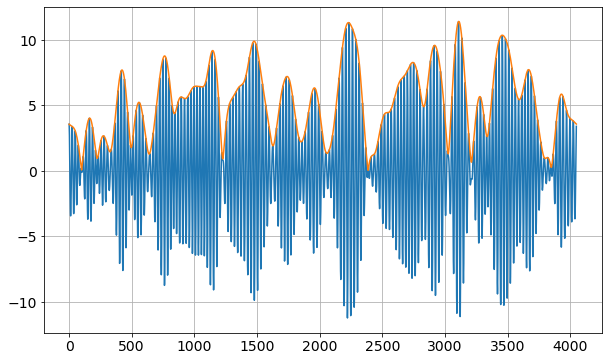

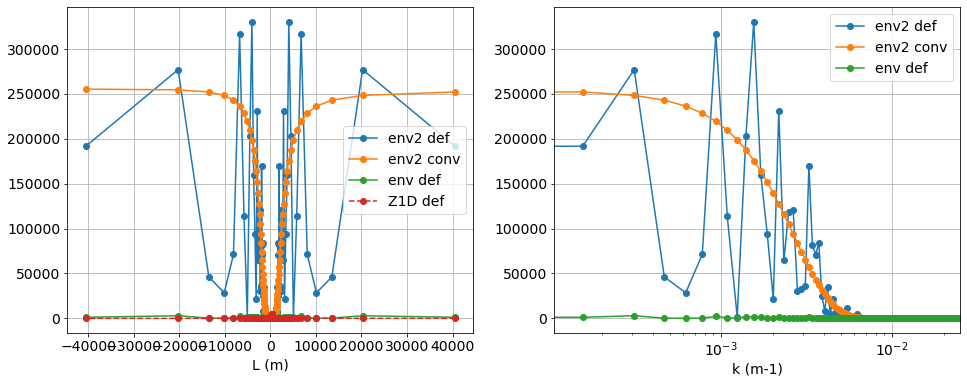

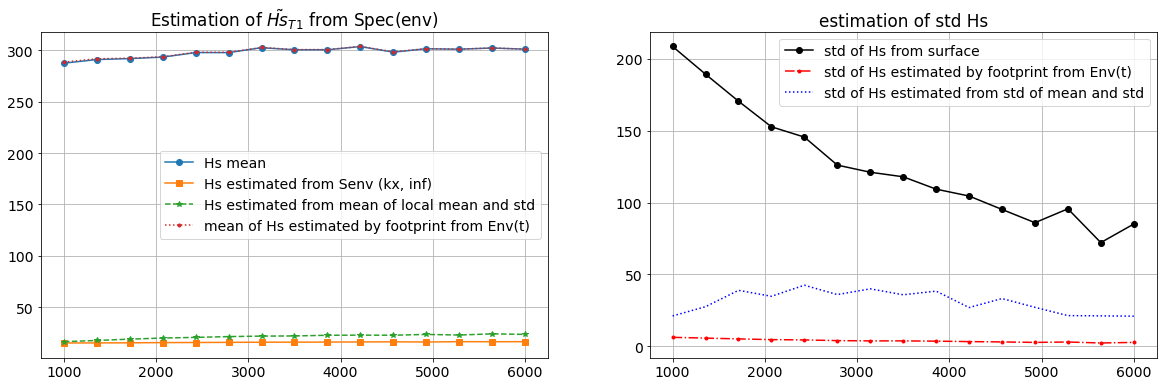

In [8]:
plt.figure()
plt.plot(S1D_r,'-')
plt.plot(np.sqrt(S1D_r**2+S1D_i**2),'-')
plt.grid(True)


fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].plot((2*np.pi)/kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[0].plot((2*np.pi)/kx,conv_1Da_shift,'o-',label='env2 conv')
axs[0].plot((2*np.pi)/kx,Spec_env1_from_1D_shifted,'o-',label='env def')
axs[0].plot((2*np.pi)/kx,Z1D_def,'o--',label='Z1D def')
axs[0].grid(True)
axs[0].set_xlabel('L (m)')
# axs[0].set_xscale('log')
axs[0].legend()

axs[1].plot(kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[1].plot(kx,conv_1Da_shift,'o-',label='env2 conv')
axs[1].plot(kx,Spec_env1_from_1D_shifted,'o-',label='env def')
# axs[1].plot(kx,Z1D_def,'o--',label='Z1D def')
axs[1].grid(True)
axs[1].set_xlabel('k (m-1)')
axs[1].set_xscale('log')
axs[1].set_xlim((-0.025,0.025))
axs[1].legend()

fig,axs=plt.subplots(1,2,figsize=(20,6))
axs[0].plot(LLs,Hs_means,'o-',label='Hs mean')
# axs[0].plot(LLs,Hs_estimated_b,label='Hs estimated from Senv (0, kx)')
axs[0].plot(LLs,Hs_estimated_a,'s-',label='Hs estimated from Senv (kx, inf)')
axs[0].plot(LLs,Hs_estimated_a_local,'*--',label='Hs estimated from mean of local mean and std')
axs[0].plot(LLs,Hs_estimated_mean,'.:',label='mean of Hs estimated by footprint from Env(t)')
                                                   
# axs[0].plot(Hs_means,Hs_estimated_a,label='Hs mean vs Hs estimated from Senv (kx, inf)')
res = stats.linregress(Hs_means, Hs_estimated_a)
print('mean envelope = ',np.mean(B1D))
print('Slope between Hs_means and Hs_estimated_a = ',res.slope,' intersection = ',res.intercept)
# axs[0].plot(LLs,stds_Z1D_below,'*--',label='sqrt(int 0 kc Z1D)')
# axs[0].plot(LLs,stds_Z1D_above,'*-.',label='sqrt(int kc inf Z1D)')
axs[0].grid(True)
axs[0].set_title(r'Estimation of $\tilde{Hs}_{T1}$ from Spec(env)')
axs[0].legend()

axs[1].plot(LLs,Hs_stds,'o-k',label='std of Hs from surface')
# axs[1].plot(LLs,stds_env2_def_from2D_below,'*--r',label='int 0_kx env2 def')
# axs[1].plot(LLs,stds_env2_conv_below,'*--g',label='int 0_kx env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_below,'*--b',label='int 0_kx env def')
axs[1].plot(LLs,Hs_estimated_std,'.-.r',label='std of Hs estimated by footprint from Env(t)')
axs[1].plot(LLs,Hs_std_estim_a,':b',label='std of Hs estimated from std of mean and std')
# axs[1].plot(LLs,stds_env2_conv_above_old,'.-.g',label='old int kx_inf env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_above_old,'.:b',label='old int kx_inf env def')
# axs[1].plot(LLs,stds_env2_def_from2D_above,'.-.r',label='int kx_inf env2 def')
# axs[1].plot(LLs,stds_env2_conv_above,'.-.g',label='int kx_inf env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_above,'.:b',label='int kx_inf env def')
axs[1].grid(True)
axs[1].set_title('estimation of std Hs')
axs[1].legend()

#     print('env not squared = ',sum_SpecenvB1Db, sum_SpecenvB1Db/np.sqrt(sum_Specenv1D))
#     print('4*sqrt(conv_1Da_pm) = ',sum_conv1Da, 'this is Hs**2 / 2, for L > Lc : ',4*std_env_squared)
#     print('4*sqrt(conv_1Db_pm) = ',sum_conv1Db, 'contains harmonics')
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
### Estimates Hs STD for L > Lc 
#convc=conv_1Db_shift
#convc[abs(kx) > kc]=0  # selects wavelengths L > Lc 
#
# surface elevation variance E = a^2/2, Hs is 4 * sqrt(E)
# envelope gives a 
# envelope squared is a^2 = 2E 
# hence local Hs is 2*sqrt(2*envelope squared) or 2*sqrt(2)*envelope
#
# Now, from the PSD of the envelope the variance of the envelope over a given range 
# of wavenumber is var_env = sum(convc*dkx), giving a std of the envelope sqrt(sum(convc*dkx))

std_env_squared=np.sqrt(sum(conv_1Da_shift[abs(kx) > kc])*dkx)
std_env_approx=std_env_squared/(np.pi*sumZ2D_def/4)
std_Hs=2*np.sqrt(2)*std_env_approx

# if isprints:
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
        

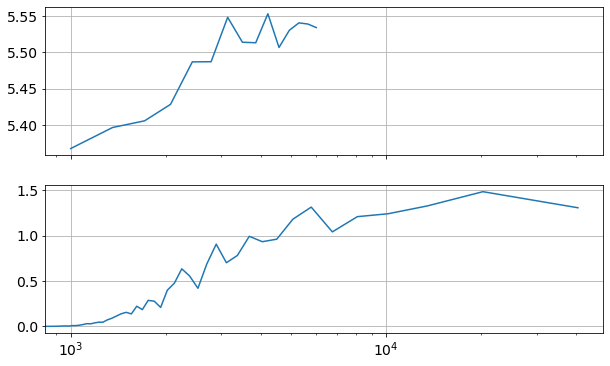

In [35]:

fig,axs=plt.subplots(2,1,sharex=True)
axs[0].plot(LLs,env_means)
axs[0].set_xscale('log')
axs[1].plot((2*np.pi)/kx,Spec_env1_from_2D_shifted/Spec_env1_from_1D_notnormal[0])


In [32]:
# investigation with a cut off
isplot=0
LM = 10000
### Get a equivalent 2D spectrum from DFT of the surface ################
# -- to verify the coefficients ------------------------------------
Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

### 1D spectrum from integration over ky 
Z1D_def = (np.sum(Z2D_def,axis=0))*dky
Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

### Generate a 1D surface based on 1D spectrum (1 realisation) #########
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(nx))
# -- from original 1D spectrum (from 2D)
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

### Envelope squared A2D and envelope B2D ###############################################
# -- 2D env
A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
B2D = np.sqrt(A2D) 
A2D = A2D-np.mean(A2D.flatten())
B2D = B2D-np.mean(B2D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
Spec_env1_2D = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

# integration over y <=> integration over realisations 
Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky

Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky

Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)
Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D)


# -- 1D env
A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
B1D = np.sqrt(A1D) 
A1D = A1D-np.mean(A1D.flatten())
# B1D = B1D-np.mean(B1D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_from_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/(dkx)
Spec_env1_from_1D = np.abs(np.fft.fft(B1D-np.mean(B1D.flatten()),norm='forward'))**2/(dkx)
Spec_env1_from_1D_notnormal = np.abs(np.fft.fft(B1D,norm='forward'))**2/(dkx) 
Spec_env2_from_1D_shifted = np.fft.fftshift(Spec_env2_from_1D)
Spec_env1_from_1D_shifted = np.fft.fftshift(Spec_env1_from_1D)
###  Convolution following Rice pp 131-133.
#conv_1D = np.convolve(Z1D_def_noshift,Z1D_def_noshift,'full')*dkx
#conv_1D_pm = conv_1D[nx//2:nx//2+nx]
conv_1D  = myconv(Z1D_def_noshift ,Z1D_def_noshift )*dkx

# This one is the definition we need: convolution with flipped single-sided spectrum
conv_1Da  = 4*myconv(Z1D_def_noshift ,np.flip(Z1D_def_noshift) )*dkx
# conv_1Db  = 8*myconv(Z1D_from_FFT_noshift ,Z1D_from_FFT_noshift )*dkx

conv_1D_shift  = np.fft.fftshift(conv_1D )
conv_1Da_shift = np.fft.fftshift(conv_1Da )
# conv_1Db_shift = np.fft.fftshift(conv_1Db )

### Check values of Hs from spectrum #####################################
# -- original 2D spectrum
sumZ2D_def=4*np.sqrt(sum(Z2D_def.flatten()*dkx*dky))
# -- reconstructed (DFT) 2D spectrum
sumZ2D_from_FFT=4*np.sqrt(sum(Z2D_from_FFT.flatten()*dkx*dky))
# -- 1D spectrum integrated from original 2D spectrum
sumZ1D_def = 4*np.sqrt(sum(Z1D_def*dkx))


if isprints:
    ##### Prints #####################################################################
    print('---- Hs estimates from spectrum : ----------------------------------')
    print('4*sqrt(Z2D_ref*dkx*dky) = ',sumZ2D_def)
    print('4*sqrt(Z2D_from_FFT*dkx*dky) = ',sumZ2D_from_FFT)
    print('4*sqrt(Z1D_ref*dkx) = ',sumZ1D_def)

### Envelope stds #####################################
A1Dstd = np.std(A1D.flatten())
B1Dstd = np.std(B1D.flatten())
sum_conv1Da   = 4*np.sqrt(sum(conv_1Da_shift*dkx))
# sum_conv1Db   = 4*np.sqrt(sum(conv_1Db_shift*dkx))
sum_Specenv2_1Db = 4*np.sqrt(sum(Spec_env2_from_1D*dkx))
sum_Specenv1_1Db = 4*np.sqrt(sum(Spec_env1_from_1D*dkx))

estim_Hs_from_env = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)#np.sum(Spec_env1_from_1D)*dkx)
estim_Hs_from_env_bis = np.sqrt(8)*np.sqrt(np.sum(Spec_env1_from_1D_notnormal)*dkx)

equiv_Hs_from_env = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
if isprints:
#     print('---- Equivalent Hs from Std of "surface" : ----------------------------------')
#     print('envelope squared :   4*std(A1D) = ',4*A1Dstd)
#     print('envelope :           4*std(B1D) = ',4*B1Dstd)
#     print(' ')
    print('')
    print('---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------')
    print('envelope :           4*std(B1D) = ',equiv_Hs_from_env)
    print(' ')
    print('---- Estimation of Hs from envelope : ----------------------------------')
    print('estimation :           Hs_estim = ',estim_Hs_from_env)
    print('estimation bis :       Hs_estim = ',estim_Hs_from_env_bis)
    print('ratio Hs/estimation = ',sumZ1D_def/estim_Hs_from_env)
    print(' ')
    print('Is variance = int_(R) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D_notnormal)*dkx,'     =>   NO !')
    print('Is variance = int_(R*) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D)*dkx,'     =>   YES !')
    print(' ')
    print('---- Envelope Hs from spectrum of envelope: -------------------')
    print('Envelope squared :')
    print('   estimation 1 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Da)
#     print('   estimation 2 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Db)
    print('   definition   :   4*sqrt(Spec_env2_from_2D*dkx) = ',sum_Specenv1Db)
    print('Envelope (definition) :')
    print('                    4*sqrt(Spec_env_from_2D*dkx) = ',sum_SpecenvB1Db)
    print('--------------------------------------------------------------')
    print('---- Estimate Hs std from surface : -------------------')    
### Estimates Hs std

mean_env = np.mean(B1D)

Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc
nLL = 15

nxtilebig = int(LM//dx) # nb pixels to have the big (scale of interest) part
extract_S1D_LM, Ntiles= extract_Welch_tiles_1D(S1D_r,nxtilebig)
extract_env1D_LM, Ntiles= extract_Welch_tiles_1D(B1D,nxtilebig)

Hs_means = np.zeros((nLL,Ntiles))
Hs_stds = np.zeros((nLL,Ntiles))

Hs_estimated_a = np.zeros(nLL)
Hs_estimated_b = np.zeros(nLL)
Hs_estimated_c = np.zeros(nLL)

LLs=np.linspace(1000,5000,nLL)
kM = 2*np.pi/LM
Ntilesfoots = np.zeros(nLL)

for index_big in range(Ntiles):
    footprints_big_S1D = extract_S1D_LM[index_big,:]
    footprints_big_Env = extract_env1D_LM[index_big,:]
    for il,LL in enumerate(LLs):
        Nxfoot = int(LL//dx) # nb pixels in footprint
        footprints_S1D_LM, Ntilesfoot = extract_Welch_tiles_1D(footprints_big_S1D,Nxfoot)
        footprints_env1D_LM, Ntilesfoot = extract_Welch_tiles_1D(footprints_big_Env,Nxfoot)
        Ntilesfoots[il]=Ntilesfoot
        if index_big==0:
            print('LL = ',LL,' ... Nb of tiles for footprint = ',Ntilesfoot)
        kc=2*np.pi/LL

        Hs_footprints_ring = 4*np.std(footprints_S1D_LM,axis=1)# vector of Hs from successive footprints
        env_means_ring = np.mean(footprints_env1D_LM,axis=1)
        
        Hs_means[il,index_big] = np.mean(Hs_footprints_ring)
        Hs_stds[il,index_big] = np.std(Hs_footprints_ring)

for il,LL in enumerate(LLs):
    kc=2*np.pi/LL
    var_env_above = np.sum(Spec_env1_from_1D_shifted[(abs(kx) >= kc)])*dkx
    var_env_below = np.sum(Spec_env1_from_1D_shifted[(abs(kx) >= kM)])*dkx
    var_env2_above = np.sum(Spec_env2_from_1D_shifted[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    var_env2_conv_above = np.sum(conv_1Da_shift[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    Hs_estimated_a[il] = ((Ntilesfoots[il]+1)/(Ntilesfoots[il]))*np.sqrt(8)*np.sqrt(mean_env**2 + var_env_above)
    Hs_estimated_b[il] = np.sqrt(8)*np.sqrt(mean_env**2 + var_env_below)
    Hs_estimated_c[il] = np.sqrt(8)*np.sqrt(mean_env**2 + var_env_above-var_env_below)
    
plt.figure()
plt.plot(S1D_r,'-')
plt.plot(np.sqrt(S1D_r**2+S1D_i**2),'-')
plt.grid(True)


fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].plot((2*np.pi)/kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[0].plot((2*np.pi)/kx,conv_1Da_shift,'o-',label='env2 conv')
axs[0].plot((2*np.pi)/kx,Spec_env1_from_1D_shifted,'o-',label='env def')
axs[0].plot((2*np.pi)/kx,Z1D_def,'o--',label='Z1D def')
axs[0].grid(True)
axs[0].set_xlabel('L (m)')
# axs[0].set_xscale('log')
axs[0].legend()

axs[1].plot(kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[1].plot(kx,conv_1Da_shift,'o-',label='env2 conv')
axs[1].plot(kx,Spec_env1_from_1D_shifted,'o-',label='env def')
# axs[1].plot(kx,Z1D_def,'o--',label='Z1D def')
axs[1].grid(True)
axs[1].set_xlabel('k (m-1)')
# axs[1].set_xscale('log')
axs[1].set_xlim((-0.025,0.025))
axs[1].legend()

fig,axs=plt.subplots(1,2,figsize=(20,6))
axs[0].plot(LLs,np.mean(Hs_means,axis=1),'o-',label='Hs mean')
# axs[0].plot(LLs,Hs_estimated_b,label='Hs estimated from Senv (0, kx)')
axs[0].plot(LLs,Hs_estimated_a,'s-',label='Hs estimated from Senv (kx, inf)')
axs[0].plot(LLs,Hs_estimated_b,'s-',label='Hs estimated from Senv (0, kM)')
# axs[0].plot(LLs,Hs_estimated_a_local,'*--',label='Hs estimated from Senv (kx, inf) and local mean')
# axs[0].plot(LLs,Hs_estimated_mean,'s-',label='mean of Hs estimated by footprint from Senv (kx, inf)')
                                                   
# axs[0].plot(Hs_means,Hs_estimated_a,label='Hs mean vs Hs estimated from Senv (kx, inf)')
res = stats.linregress(np.mean(Hs_means,axis=1), Hs_estimated_a)
print('mean envelope = ',np.mean(B1D))
print('Slope between Hs_means and Hs_estimated_a = ',res.slope,' intersection = ',res.intercept)
# axs[0].plot(LLs,stds_Z1D_below,'*--',label='sqrt(int 0 kc Z1D)')
# axs[0].plot(LLs,stds_Z1D_above,'*-.',label='sqrt(int kc inf Z1D)')
axs[0].grid(True)
axs[0].set_title(r'Estimation of $\tilde{Hs}_{T1}$ from Spec(env)')
axs[0].legend()

axs[1].plot(LLs,np.mean(Hs_stds,axis=1),'o-k',label='std from surface')
axs[1].plot(LLs,Hs_estimated_b/Hs_estimated_a,'*-b',label='std from surface')
axs[1].plot(LLs,Hs_estimated_c,'*--r',label='estimated_c')
# axs[1].plot(LLs,stds_env2_def_from2D_below,'*--r',label='int 0_kx env2 def')
# axs[1].plot(LLs,stds_env2_conv_below,'*--g',label='int 0_kx env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_below,'*--b',label='int 0_kx env def')
# axs[1].plot(LLs,stds_env2_def_from2D_above,'.-.r',label='int kx_inf env2 def')
# axs[1].plot(LLs,stds_env2_conv_above,'.-.g',label='int kx_inf env2 conv')
# axs[1].plot(LLs,stds_env_def_from2D_above,'.:b',label='int kx_inf env def')
axs[1].grid(True)
axs[1].legend()

#     print('env not squared = ',sum_SpecenvB1Db, sum_SpecenvB1Db/np.sqrt(sum_Specenv1D))
#     print('4*sqrt(conv_1Da_pm) = ',sum_conv1Da, 'this is Hs**2 / 2, for L > Lc : ',4*std_env_squared)
#     print('4*sqrt(conv_1Db_pm) = ',sum_conv1Db, 'contains harmonics')
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
### Estimates Hs STD for L > Lc 
#convc=conv_1Db_shift
#convc[abs(kx) > kc]=0  # selects wavelengths L > Lc 
#
# surface elevation variance E = a^2/2, Hs is 4 * sqrt(E)
# envelope gives a 
# envelope squared is a^2 = 2E 
# hence local Hs is 2*sqrt(2*envelope squared) or 2*sqrt(2)*envelope
#
# Now, from the PSD of the envelope the variance of the envelope over a given range 
# of wavenumber is var_env = sum(convc*dkx), giving a std of the envelope sqrt(sum(convc*dkx))

std_env_squared=np.sqrt(sum(conv_1Da_shift[abs(kx) > kc])*dkx)
std_env_approx=std_env_squared/(np.pi*sumZ2D_def/4)
std_Hs=2*np.sqrt(2)*std_env_approx

# if isprints:
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
        

---- Hs estimates from spectrum : ----------------------------------
4*sqrt(Z2D_ref*dkx*dky) =  16.86548085423178
4*sqrt(Z2D_from_FFT*dkx*dky) =  16.86548085423167
4*sqrt(Z1D_ref*dkx) =  16.865480854231926

---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------
envelope :           4*std(B1D) =  15.07811595294591
 
---- Estimation of Hs from envelope : ----------------------------------
estimation :           Hs_estim =  16.865480854231937
estimation bis :       Hs_estim =  16.86548085423193
ratio Hs/estimation =  0.9999999999999993
 
Is variance = int_(R) Spec  ? 
7.136857969247753  =?=  35.555555555557966      =>   NO !
Is variance = int_(R*) Spec  ? 
7.136857969247753  =?=  7.136857969247752      =>   YES !
 
---- Envelope Hs from spectrum of envelope: -------------------
Envelope squared :
   estimation 1 :   4*sqrt(Spec_conv*dkx) =  142.22222222223186


NameError: name 'sum_Specenv1Db' is not defined

In [67]:
print(kc)
print(kM)

0.0012566370614359172
0.0006283185307179586


In [ ]:
# investigation with a cut off: Welch's similar
isplot=0
LM = 10000
### Get a equivalent 2D spectrum from DFT of the surface ################
# -- to verify the coefficients ------------------------------------
Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

### 1D spectrum from integration over ky 
Z1D_def = (np.sum(Z2D_def,axis=0))*dky
Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

### Generate a 1D surface based on 1D spectrum (1 realisation) #########
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(nx))
# -- from original 1D spectrum (from 2D)
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_r = np.real(np.fft.ifft(zhats,norm="forward"))
S1D_i = np.imag(np.fft.ifft(zhats,norm="forward"))

### Envelope squared A2D and envelope B2D ###############################################
# -- 2D env
A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
B2D = np.sqrt(A2D) 
A2D = A2D-np.mean(A2D.flatten())
B2D = B2D-np.mean(B2D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_2D = np.abs(np.fft.fft2(A2D,norm='forward'))**2/(dky*dkx)
Spec_env1_2D = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

# integration over y <=> integration over realisations 
Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky

Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky

Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)
Spec_env1_from_2D_shifted = np.fft.fftshift(Spec_env1_from_2D)


# -- 1D env
A1D = (S1D_r**2+S1D_i**2) # S1 is real part, S2 is imaginary part
B1D = np.sqrt(A1D) 
A1D = A1D-np.mean(A1D.flatten())
# B1D = B1D-np.mean(B1D.flatten())

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_from_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/(dkx)
Spec_env1_from_1D = np.abs(np.fft.fft(B1D-np.mean(B1D.flatten()),norm='forward'))**2/(dkx)
Spec_env1_from_1D_notnormal = np.abs(np.fft.fft(B1D,norm='forward'))**2/(dkx) 
Spec_env2_from_1D_shifted = np.fft.fftshift(Spec_env2_from_1D)
Spec_env1_from_1D_shifted = np.fft.fftshift(Spec_env1_from_1D)
###  Convolution following Rice pp 131-133.
#conv_1D = np.convolve(Z1D_def_noshift,Z1D_def_noshift,'full')*dkx
#conv_1D_pm = conv_1D[nx//2:nx//2+nx]
conv_1D  = myconv(Z1D_def_noshift ,Z1D_def_noshift )*dkx

# This one is the definition we need: convolution with flipped single-sided spectrum
conv_1Da  = 4*myconv(Z1D_def_noshift ,np.flip(Z1D_def_noshift) )*dkx
# conv_1Db  = 8*myconv(Z1D_from_FFT_noshift ,Z1D_from_FFT_noshift )*dkx

conv_1D_shift  = np.fft.fftshift(conv_1D )
conv_1Da_shift = np.fft.fftshift(conv_1Da )
# conv_1Db_shift = np.fft.fftshift(conv_1Db )

### Check values of Hs from spectrum #####################################
# -- original 2D spectrum
sumZ2D_def=4*np.sqrt(sum(Z2D_def.flatten()*dkx*dky))
# -- reconstructed (DFT) 2D spectrum
sumZ2D_from_FFT=4*np.sqrt(sum(Z2D_from_FFT.flatten()*dkx*dky))
# -- 1D spectrum integrated from original 2D spectrum
sumZ1D_def = 4*np.sqrt(sum(Z1D_def*dkx))


if isprints:
    ##### Prints #####################################################################
    print('---- Hs estimates from spectrum : ----------------------------------')
    print('4*sqrt(Z2D_ref*dkx*dky) = ',sumZ2D_def)
    print('4*sqrt(Z2D_from_FFT*dkx*dky) = ',sumZ2D_from_FFT)
    print('4*sqrt(Z1D_ref*dkx) = ',sumZ1D_def)

### Envelope stds #####################################
A1Dstd = np.std(A1D.flatten())
B1Dstd = np.std(B1D.flatten())
sum_conv1Da   = 4*np.sqrt(sum(conv_1Da_shift*dkx))
# sum_conv1Db   = 4*np.sqrt(sum(conv_1Db_shift*dkx))
sum_Specenv2_1Db = 4*np.sqrt(sum(Spec_env2_from_1D*dkx))
sum_Specenv1_1Db = 4*np.sqrt(sum(Spec_env1_from_1D*dkx))

estim_Hs_from_env = np.sqrt(8)*np.sqrt(np.mean(B1D.flatten())**2 + np.std(B1D.flatten())**2)#np.sum(Spec_env1_from_1D)*dkx)
estim_Hs_from_env_bis = np.sqrt(8)*np.sqrt(np.sum(Spec_env1_from_1D_notnormal)*dkx)

equiv_Hs_from_env = 2*np.sqrt(2)*(np.mean(B1D.flatten()))
if isprints:
#     print('---- Equivalent Hs from Std of "surface" : ----------------------------------')
#     print('envelope squared :   4*std(A1D) = ',4*A1Dstd)
#     print('envelope :           4*std(B1D) = ',4*B1Dstd)
#     print(' ')
    print('')
    print('---- Equivalent Hs from mean of "surface envelope" (2 * env ~ Hrms) : --------------')
    print('envelope :           4*std(B1D) = ',equiv_Hs_from_env)
    print(' ')
    print('---- Estimation of Hs from envelope : ----------------------------------')
    print('estimation :           Hs_estim = ',estim_Hs_from_env)
    print('estimation bis :       Hs_estim = ',estim_Hs_from_env_bis)
    print('ratio Hs/estimation = ',sumZ1D_def/estim_Hs_from_env)
    print(' ')
    print('Is variance = int_(R) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D_notnormal)*dkx,'     =>   NO !')
    print('Is variance = int_(R*) Spec  ? ')
    print(np.std(B1D.flatten())**2, ' =?= ',np.sum(Spec_env1_from_1D)*dkx,'     =>   YES !')
    print(' ')
    print('---- Envelope Hs from spectrum of envelope: -------------------')
    print('Envelope squared :')
    print('   estimation 1 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Da)
#     print('   estimation 2 :   4*sqrt(Spec_conv*dkx) = ',sum_conv1Db)
    print('   definition   :   4*sqrt(Spec_env2_from_2D*dkx) = ',sum_Specenv1Db)
    print('Envelope (definition) :')
    print('                    4*sqrt(Spec_env_from_2D*dkx) = ',sum_SpecenvB1Db)
    print('--------------------------------------------------------------')
    print('---- Estimate Hs std from surface : -------------------')    
### Estimates Hs std

mean_env = np.mean(B1D)

Lc=4000 # cut-off wavelength approximating effect of altimeter footprint
kc=2*np.pi/Lc
nLL = 15

Nbig = int(LM//dx) # nb pixels to have the big (scale of interest) part
Hs_means = np.zeros((nLL,nx-Nbig))
Hs_estimated_mean = np.zeros(nLL)
Hs_estimated_std = np.zeros(nLL)
Hs_estimated_b = np.zeros(nLL)
Hs_estimated_a = np.zeros(nLL)
Hs_estimated_a_local = np.zeros(nLL)
Hs_estimated_a_local_std = np.zeros(nLL)
Hs_estimated_a_local_std_p = np.zeros(nLL)
Hs_estimated_a_local_std_m = np.zeros(nLL)
Hs_stds = np.zeros((nLL,nx-Nbig))
env_means = np.zeros(nLL)
env_stds = np.zeros(nLL)

stds_env2_def_from2D_below = np.zeros(nLL)
stds_env2_conv_below = np.zeros(nLL)
stds_env_def_from2D_below = np.zeros(nLL)
stds_env2_def_from2D_above = np.zeros(nLL)
stds_env2_conv_above = np.zeros(nLL)
stds_env_def_from2D_above = np.zeros(nLL)
stds_Z1D_below = np.zeros(nLL)
stds_Z1D_above = np.zeros(nLL)

LLs=np.linspace(1000,5000,nLL)
kM = 2*np.pi/LM
# footprints_big_S1D =np.zeros((Nbig,nx-Nbig))
# footprints_big_Env=np.zeros((Nbig,nx-Nbig))
for index_big in range(nx - Nbig):
    footprints_big_S1D = S1D_r[index_big:index_big + Nbig]
    footprints_big_Env = B1D[index_big:index_big + Nbig]
    for il,LL in enumerate(LLs):
        Nfoot = int(LL//dx)
        footprints_S1D = np.zeros((Nfoot,(nx-Nbig)-Nfoot))
        footprints_Env = np.zeros((Nfoot,(nx-Nbig)-Nfoot))
        kc=2*np.pi/LL
        for infoot in range((nx-Nbig)-Nfoot):
            print('total =',np.shape(footprints_big_S1D))
            print('left = ',np.shape(footprints_S1D))
            print('right =',np.shape(footprints_big_S1D[infoot:infoot+Nfoot]))
            footprints_S1D[:,infoot]=footprints_big_S1D[infoot:infoot+Nfoot]
            footprints_Env[:,infoot]=footprints_big_S1D[infoot:infoot+Nfoot]

        Hs_footprints_ring = 4*np.std(footprints_S1D,axis=0) # vector of Hs from successive footprints
        env_means_ring = np.mean(footprints_Env,axis=0)
        
        Hs_means[il,index_big] = np.mean(Hs_footprints_ring)
        Hs_stds[il,index_big] = np.std(Hs_footprints_ring)
#     env_means[il] = np.mean(env_means_ring)
#     env_stds[il] = np.std(env_means_ring)
#     Hs_stds[il] = np.std(Hs_footprints_ring)
#     stds_Z1D_below[il] = 4*np.sqrt(sum(Z1D_def[abs(kx) < kc])*dkx)
#     stds_Z1D_above[il] = 4*np.sqrt(sum(Z1D_def[abs(kx) > kc])*dkx)
#     Hs_estimated_b[il] = np.sqrt(8)*np.sqrt(mean_env**2+np.sum(Spec_envB_from_1D_shifted[abs(kx) < kc])*dkx)

for il,LL in enumerate(LLs):
    kc=2*np.pi/LL
    var_env_above = np.sum(Spec_env1_from_1D_shifted[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    var_env2_above = np.sum(Spec_env2_from_1D_shifted[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    var_env2_conv_above = np.sum(conv_1Da_shift[(abs(kx) >= kc)&(abs(kx) <= kM)])*dkx
    Hs_estimated_a[il] = np.sqrt(8)*np.sqrt(mean_env**2 + var_env_above)
    
    
#     # --- computations from spectrums
# #     conv_1Da_shift,Spec_env_from_2D,Spec_envB_from_2D
#     stds_env2_def_from2D_below[il] = 4*np.sqrt(var_env2_below)
#     stds_env2_conv_below[il] = 4*np.sqrt(var_env2_conv_below)
#     stds_env_def_from2D_below[il] = 4*np.sqrt(var_env_below)
    
#     stds_env2_def_from2D_above[il] = 4*np.sqrt(var_env2_above)
#     stds_env2_conv_above[il] = 4*np.sqrt(var_env2_conv_above)
#     stds_env_def_from2D_above[il] = 4*np.sqrt(var_env_above)
    
#     if isprints:
#         print('---- LL = ',LL)
#         print('     Hs mean = ', Hs_mean_ring)
#         print('     Hs std = ', Hs_std_ring)

plt.figure()
plt.plot(S1D_r,'-')
plt.plot(np.sqrt(S1D_r**2+S1D_i**2),'-')
plt.grid(True)


fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].plot((2*np.pi)/kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[0].plot((2*np.pi)/kx,conv_1Da_shift,'o-',label='env2 conv')
axs[0].plot((2*np.pi)/kx,Spec_env1_from_1D_shifted,'o-',label='env def')
axs[0].plot((2*np.pi)/kx,Z1D_def,'o--',label='Z1D def')
axs[0].grid(True)
axs[0].set_xlabel('L (m)')
# axs[0].set_xscale('log')
axs[0].legend()

axs[1].plot(kx,Spec_env2_from_1D_shifted,'o-',label='env2 def')
axs[1].plot(kx,conv_1Da_shift,'o-',label='env2 conv')
axs[1].plot(kx,Spec_env1_from_1D_shifted,'o-',label='env def')
# axs[1].plot(kx,Z1D_def,'o--',label='Z1D def')
axs[1].grid(True)
axs[1].set_xlabel('k (m-1)')
# axs[1].set_xscale('log')
axs[1].set_xlim((-0.025,0.025))
axs[1].legend()

fig,axs=plt.subplots(1,2,figsize=(20,6))
axs[0].plot(LLs,Hs_means,'o-',label='Hs mean')
# axs[0].plot(LLs,Hs_estimated_b,label='Hs estimated from Senv (0, kx)')
axs[0].plot(LLs,Hs_estimated_a,'s-',label='Hs estimated from Senv (kx, inf)')
# axs[0].plot(LLs,Hs_estimated_a_local,'*--',label='Hs estimated from Senv (kx, inf) and local mean')
# axs[0].plot(LLs,Hs_estimated_mean,'s-',label='mean of Hs estimated by footprint from Senv (kx, inf)')
                                                   
# axs[0].plot(Hs_means,Hs_estimated_a,label='Hs mean vs Hs estimated from Senv (kx, inf)')
res = stats.linregress(Hs_means, Hs_estimated_a)
print('mean envelope = ',np.mean(B1D))
print('Slope between Hs_means and Hs_estimated_a = ',res.slope,' intersection = ',res.intercept)
# axs[0].plot(LLs,stds_Z1D_below,'*--',label='sqrt(int 0 kc Z1D)')
# axs[0].plot(LLs,stds_Z1D_above,'*-.',label='sqrt(int kc inf Z1D)')
axs[0].grid(True)
axs[0].set_title(r'Estimation of $\tilde{Hs}_{T1}$ from Spec(env)')
axs[0].legend()

axs[1].plot(LLs,Hs_stds,'o-k',label='std from surface')
axs[1].plot(LLs,stds_env2_def_from2D_below,'*--r',label='int 0_kx env2 def')
axs[1].plot(LLs,stds_env2_conv_below,'*--g',label='int 0_kx env2 conv')
axs[1].plot(LLs,stds_env_def_from2D_below,'*--b',label='int 0_kx env def')
axs[1].plot(LLs,stds_env2_def_from2D_above,'.-.r',label='int kx_inf env2 def')
axs[1].plot(LLs,stds_env2_conv_above,'.-.g',label='int kx_inf env2 conv')
axs[1].plot(LLs,stds_env_def_from2D_above,'.:b',label='int kx_inf env def')
axs[1].grid(True)
axs[1].legend()

#     print('env not squared = ',sum_SpecenvB1Db, sum_SpecenvB1Db/np.sqrt(sum_Specenv1D))
#     print('4*sqrt(conv_1Da_pm) = ',sum_conv1Da, 'this is Hs**2 / 2, for L > Lc : ',4*std_env_squared)
#     print('4*sqrt(conv_1Db_pm) = ',sum_conv1Db, 'contains harmonics')
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
### Estimates Hs STD for L > Lc 
#convc=conv_1Db_shift
#convc[abs(kx) > kc]=0  # selects wavelengths L > Lc 
#
# surface elevation variance E = a^2/2, Hs is 4 * sqrt(E)
# envelope gives a 
# envelope squared is a^2 = 2E 
# hence local Hs is 2*sqrt(2*envelope squared) or 2*sqrt(2)*envelope
#
# Now, from the PSD of the envelope the variance of the envelope over a given range 
# of wavenumber is var_env = sum(convc*dkx), giving a std of the envelope sqrt(sum(convc*dkx))

std_env_squared=np.sqrt(sum(conv_1Da_shift[abs(kx) > kc])*dkx)
std_env_approx=std_env_squared/(np.pi*sumZ2D_def/4)
std_Hs=2*np.sqrt(2)*std_env_approx

# if isprints:
#     print('--------------------------------------------------------------')
#     print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
#     print(std_Hs)
        

In [ ]:
# breakpoint

In [8]:
print('mean envelope = ',np.mean(B1D))
print('equiv mean from spectrum = ',np.sqrt(Spec_envB_from_1D_shifted[nx//2]*dkx))
print('sqrt(Hs) = ',np.sqrt(Hs))

mean envelope =  1.966553747535086
equiv mean from spectrum =  1.966553747535086
sqrt(Hs) =  2.449489742783178


In [10]:
kx[nx//2]#:nx//2+3]

0.0

---- Hs estimates : ----------------------------------
4*sqrt(Z2D_ref*dkx*dky) =  13.99999999999972
4*sqrt(Z1D_ref*dkx) =  13.99999999999972

---- Envelope squared std : ----------------------------------
4*std(A2D),4*std(A1D) =  94.2062273228768 76.28638280739892
---- Envelope std (pi*Hs/4 times smaller): -------------------
4*std(B2D),4*std(B1D) =  9.072735367753998 7.423763830621054 4*A2Dstd/(pi*Hs/4) 8.567649570557093
4*sqrt(Specenv1D*dkx) =  124.19183629303599
4*sqrt(Specenv1Db*dkx) =  94.20622732287679
env not squared =  19.79898987322293 1.7766280279286604
4*sqrt(conv_1Da_pm) =  97.9999999999961 this is Hs**2 / 2, for L > Lc :  76.37132062392489
4*sqrt(conv_1Db_pm) =  138.59292911255787 contains harmonics
--------------------------------------------------------------
From the wave directional spectrum, we predict std(Hs) for L > 3km: 
4.911310431727618


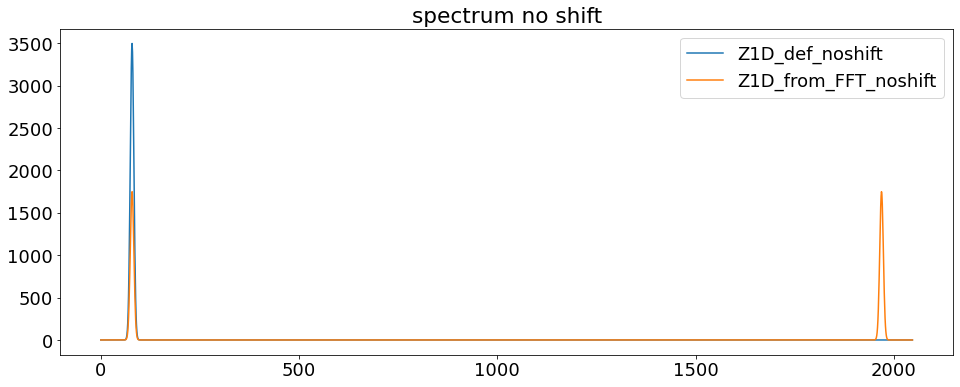

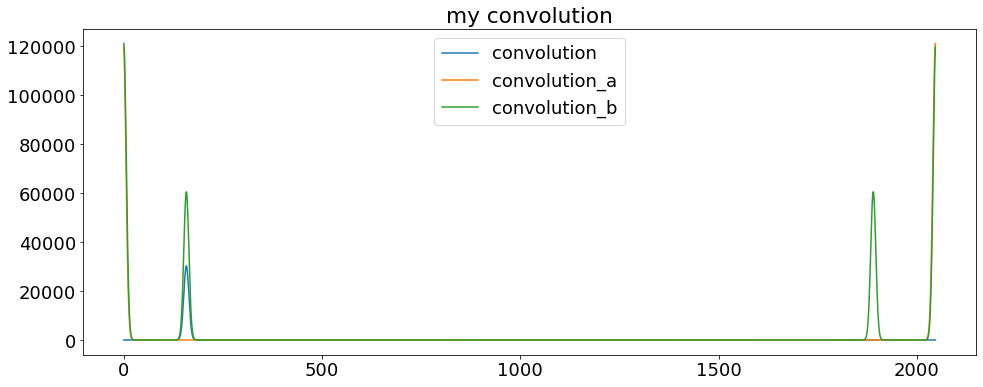

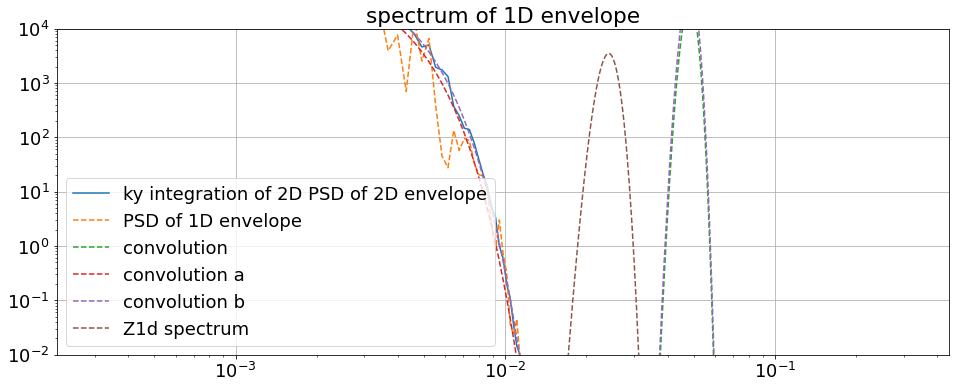

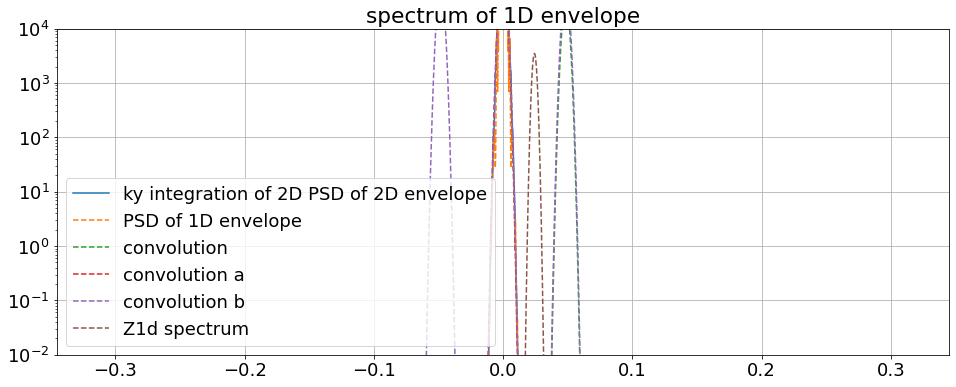

In [7]:
### Get a equivalent 2D spectrum from DFT of the surface ################
# -- to verify the coefficients ------------------------------------
Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

### 1D spectrum from integration over ky 
Z1D_def = (np.sum(Z2D_def*dky,axis=0))
Z1D_def_noshift=np.fft.ifftshift(Z1D_def)

# -- reconstructed (DFT) 2D spectrum
Z1D_from_FFT_noshift = np.sum(Z2D_from_FFT*dky,axis=0) 
Z1D_from_FFT = np.fft.fftshift(np.sum(Z2D_from_FFT*dky,axis=0)) # fftshift to have the values from -k_lim to k_lim
# set the spectrum only to positive part (equiv to Z2_def) => easier to generate surface
Z1D_from_FFT[0:nx//2]=0
Z1D_from_FFT[nx//2:]=2*Z1D_from_FFT[nx//2:] 

### Generate a 1D surface based on 1D spectrum (1 realisation) #########
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(nx))
# -- from original 1D spectrum (from 2D)
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_def_r = np.real(np.fft.ifft(zhats,norm="forward"))
# -- from 2D spectrum from 2D FFT spectrum
zhats=np.sqrt(2*np.fft.ifftshift(Z1D_from_FFT)*dkx)*np.exp(1j*2*np.pi*rg)
S1D_from_FFT = (np.fft.ifft(zhats,norm="forward"))

### Generate associated spectrum to S1D ################################
Z1D_from_S1D_complex = np.fft.fftshift(np.fft.fft(S1D_from_FFT.real,norm="forward")) # Z33
Z1D_from_S1D = np.sqrt(np.abs(Z1D_from_S1D_complex)**2)

### Envelope squared and envelope ###############################################
# -- 2D env
A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
B2D = np.sqrt(A2D) 

# ---- Spectrum of A = spectrum of envelope squared from 2D Surface ---------------
Spec_env2_2D = np.abs(np.fft.fft2(A2D-np.mean(A2D.flatten()),norm='forward'))**2/(dky*dkx)
Spec_env1_2D = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky*dkx)

# integration over y <=> integration over realisations 
Spec_env2_from_2D = np.sum(Spec_env2_2D,axis=0)*dky

Spec_env1_from_2D = np.sum(Spec_env1_2D,axis=0)*dky

Spec_env2_from_2D_shifted = np.fft.fftshift(Spec_env2_from_2D)

A1D = S1D_from_FFT.real**2+S1D_from_FFT.imag**2
B1D = np.sqrt(A1D)



# ---- Spectrum of B = spectrum of enveloppe from 1D Surface ---------------
# warning, this is a double-sided spectrum
Spec_env_1D = np.abs(np.fft.fft(A1D,norm='forward'))**2/dkx
Spec_env_1D_shifted = np.fft.fftshift(Spec_env_1D)


###  Convolution following Rice pp 131-133.
#conv_1D = np.convolve(Z1D_def_noshift,Z1D_def_noshift,'full')*dkx
#conv_1D_pm = conv_1D[nx//2:nx//2+nx]
conv_1D  = myconv(Z1D_def_noshift ,Z1D_def_noshift )*dkx

# This one is the definition we need: convolution with flipped single-sided spectrum
conv_1Da  = 4*myconv(Z1D_def_noshift ,np.flip(Z1D_def_noshift) )*dkx
conv_1Db  = 8*myconv(Z1D_from_FFT_noshift ,Z1D_from_FFT_noshift )*dkx


conv_1D_shift  = np.fft.fftshift(conv_1D )
conv_1Da_shift = np.fft.fftshift(conv_1Da )
conv_1Db_shift = np.fft.fftshift(conv_1Db )


### Check values of Hs from spectrum #####################################
# -- original 2D spectrum
sumZ2D_def=4*np.sqrt(sum(Z2D_def.flatten()*dkx*dky))
# -- reconstructed (DFT) 2D spectrum
sumZ2D_from_FFT=4*np.sqrt(sum(Z2D_from_FFT.flatten()*dkx*dky))
# -- 1D spectrum integrated from original 2D spectrum
sumZ1D_def = 4*np.sqrt(sum(Z1D_def*dkx))
# -- 1D spectrum integrated from reconstructed (DFT) 2D spectrum
sumZ1D_from_FFT = 4*np.sqrt(sum(Z1D_from_FFT*dkx))
# -- 1D spectrum calculated from 1D surface (from FFT)
sumZ1D_from_S1D = 4*np.sqrt(sum(Z1D_from_S1D**2))

### Envelope stds #####################################
A1Dstd=np.std(A1D.flatten())
A2Dstd=np.std(A2D.flatten())
B1Dstd=np.std(B1D.flatten())
B2Dstd=np.std(B2D.flatten())
sum_Specenv1D =4*np.sqrt(sum(Spec_env_1D*dkx))
sum_conv1Da   =4*np.sqrt(sum(conv_1Da_shift*dkx))
sum_Specenv2_1Db=4*np.sqrt(sum(Spec_env2_from_2D*dkx))
sum_Specenv1_1Db=4*np.sqrt(sum(Spec_env1_from_2D*dkx))
sum_conv1Db   =4*np.sqrt(sum(conv_1Db_shift*dkx))

### Estimates Hs STD for L > Lc 
#convc=conv_1Db_shift
#convc[abs(kx) > kc]=0  # selects wavelengths L > Lc 
#
# surface elevation variance E = a^2/2, Hs is 4 * sqrt(E)
# envelope gives a 
# envelope squared is a^2 = 2E 
# hence local Hs is 2*sqrt(2*envelope squared) or 2*sqrt(2)*envelope
#
# Now, from the PSD of the envelope the variance of the envelope over a given range 
# of wavenumber is var_env = sum(convc*dkx), giving a std of the envelope sqrt(sum(convc*dkx))

std_env_squared=np.sqrt(sum(conv_1Db_shift[abs(kx) < kc])*dkx)
std_env_approx=std_env_squared/(np.pi*sumZ2D_def/4)
std_Hs=2*np.sqrt(2)*std_env_approx


k1 = np.argmin(np.abs(kx-(-0.03)))
k2 = np.argmin(np.abs(kx-0.03))
if isplot:
    ##### spectrum  ######
    fig,axs=plt.subplots(1,1,figsize=(16,6))
    plt.plot(Z1D_def_noshift ,label='Z1D_def_noshift')
    plt.plot(Z1D_from_FFT_noshift ,label='Z1D_from_FFT_noshift')
    plt.legend()
    _=axs.set_title('spectrum no shift')

    ##### convolution  ######
    fig,axs=plt.subplots(1,1,figsize=(16,6))
    plt.plot(conv_1D,label='convolution')
    plt.plot(conv_1Da,label='convolution_a')
    plt.plot(conv_1Db,label='convolution_b')
    plt.legend()
    _=axs.set_title('my convolution')

    ##### spectrum of enveloppe from 2D and  1D log scale  ######
    fig,axs=plt.subplots(1,1,figsize=(16,6))
    plt.plot(kx,Spec_env2_from_2D_shifted,label='ky integration of 2D PSD of 2D envelope')
    plt.plot(kx,Spec_env_1D_shifted,'--',label='PSD of 1D envelope')
    plt.plot(kx,conv_1D_shift,'--',label='convolution')
    plt.plot(kx,conv_1Da_shift,'--',label='convolution a')
    plt.plot(kx,conv_1Db_shift,'--',label='convolution b')
    plt.plot(kx,Z1D_def,'--',label='Z1d spectrum')
    _=axs.set_title('spectrum of 1D envelope')
    plt.grid(True)
    _=plt.ylim(10**-2,10**4)
    # plt.xlim((-0.1,0.1))
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()

            ##### spectrum of enveloppe from 2D and  1D  ######
    fig,axs=plt.subplots(1,1,figsize=(16,6))
    plt.plot(kx,Spec_env2_from_2D_shifted,label='ky integration of 2D PSD of 2D envelope')
    plt.plot(kx,Spec_env_1D_shifted,'--',label='PSD of 1D envelope')
    plt.plot(kx,conv_1D_shift,'--',label='convolution')
    plt.plot(kx,conv_1Da_shift,'--',label='convolution a')
    plt.plot(kx,conv_1Db_shift,'--',label='convolution b')
    plt.plot(kx,Z1D_def,'--',label='Z1d spectrum')
    _=axs.set_title('spectrum of 1D envelope')
    plt.grid(True)
    _=plt.ylim(10**-2,10**4)
    # plt.xlim((-0.1,0.1))
    plt.yscale('log')
    plt.legend()



if isprints:
    ##### Prints #####################################################################
    print('---- Hs estimates : ----------------------------------')
    print('4*sqrt(Z2D_ref*dkx*dky) = ',sumZ2D_def)
    print('4*sqrt(Z1D_ref*dkx) = ',sumZ1D_def)
    print('')
    print('---- Envelope squared std : ----------------------------------')
    print('4*std(A2D),4*std(A1D) = ',4*A2Dstd,4*A1Dstd)
    print('---- Envelope std (pi*Hs/4 times smaller): -------------------')
    print('4*std(B2D),4*std(B1D) = ',4*B2Dstd,4*B1Dstd,'4*A2Dstd/(pi*Hs/4)',4*A2Dstd/(np.pi*sumZ2D_def/4))
    print('4*sqrt(Specenv1D*dkx) = ',sum_Specenv1D)
    print('4*sqrt(Specenv1Db*dkx) = ',sum_Specenv1Db)
    print('env not squared = ',sum_SpecenvB1Db, sum_SpecenvB1Db/np.sqrt(sum_Specenv1D))
    print('4*sqrt(conv_1Da_pm) = ',sum_conv1Da, 'this is Hs**2 / 2, for L > Lc : ',4*std_env_squared)
    print('4*sqrt(conv_1Db_pm) = ',sum_conv1Db, 'contains harmonics')
    print('--------------------------------------------------------------')
    print('From the wave directional spectrum, we predict std(Hs) for L > 3km: ')
    print(std_Hs)

        

In [8]:
freq_satsampl=40 # freq for waveforms
v_sat=7000 # satellite velocity in m/s
alti_sat=519000 # altitude of satellite CFOSAT
# WARNING: the following 4 parameters should probably be adjusted as a function of the wave height ... 
radi = 4000     # radius used to compute waveform
radi1 = 900     # inner radius for Hs average
radi2 = 1200    # outer radius for Hs average
range_shift = 10 # shift of the waveforms from the "epoch" in meters

isplot_steps=0
# --- edges for range windows ------------
dr = 0.4
edges_max = 20

nHs=251
Hs_max = 25

wfm_ref, Hsm_ref, edges_ref = generate_wvform_database(dr,nHs,edges_max=edges_max,Hs_max=Hs_max,offset=range_shift)

nxa=np.floor(radi/dx).astype(int) # size of radius of footprint in pixel
di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)
nsamp=np.floor((nx-2*nxa)/di).astype(int) # Nb of samples

Hs_std,Hs_stdbis,Hs_std2,Hs_retrack,Xalt,waveforms,surf1,footprint1 = fly_over_track_v0(X,Y,S2D_r,nsamp,nxa,di,wfm_ref,Hsm_ref,edges_ref,radi,radi1,radi2,alti_sat,range_shift)


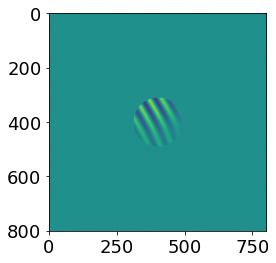

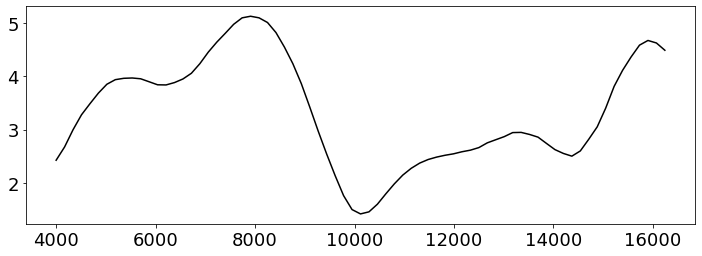

In [9]:
plt.imshow(np.flipud(surf1),vmin=-4, vmax=4)

fig,ax=plt.subplots(figsize=(12,4))
plt.plot(Xalt,Hs_std,color='k',label='python')


In [10]:
surf2 = np.nan*np.ones(surf1.shape)
surf2[footprint1>0]=surf1[footprint1>0]

Hs_std1 = 4*np.std(surf1)/np.sqrt(np.mean(footprint1))
Hs_std12 = 4*np.nanstd(surf2)#/np.sqrt(np.mean(footprint1))
print('Hs std1 = ',Hs_std1,' - Hs std2 = ',Hs_std12)

Hs std1 =  4.489025472155908  - Hs std2 =  4.48901516593509


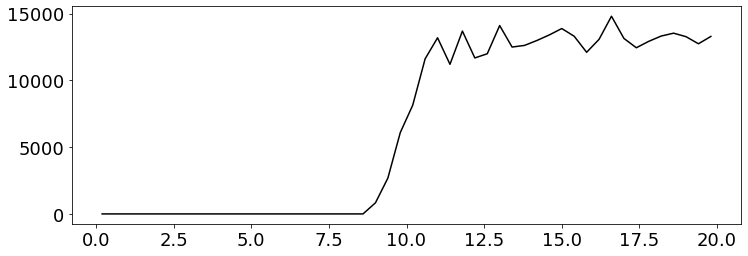

In [11]:

fig,ax=plt.subplots(figsize=(12,4))
plt.plot(edges_ref[0:-1]+dr/2,waveforms[0,:],color='k',label='python')


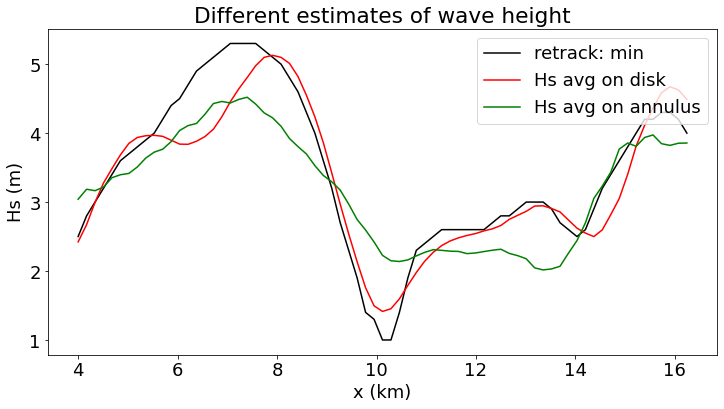

In [12]:
fig,ax=plt.subplots(figsize=(12,6))
line1=plt.plot(Xalt*0.001, Hs_retrack, color='k',label='retrack: min')
line2=plt.plot(Xalt*0.001, Hs_std, color='r',label='Hs avg on disk')
line3=plt.plot(Xalt*0.001, Hs_std2, color='g',label='Hs avg on annulus')
plt.grid
plt.xlabel('x (km)')
plt.ylabel('Hs (m)')
plt.title('Different estimates of wave height')
leg = plt.legend(loc='upper right')
plt.show()

int |cos(x)| =  0.6373475821202027
int |sin(x)| =  0.635344434229173
int cos(x)**2 =  0.501
int sin(x)**2 =  0.499
int cos(x)**2+sin(x)**2 =  1.0
int sqrt(cos(x)**2+sin(x)**2) =  1.0
1.2721508625153746
1.4142135623730951
1.5707963267948966
1.2533141373155001
1.2599210498948732
1.7724538509055159
1.4645918875615231


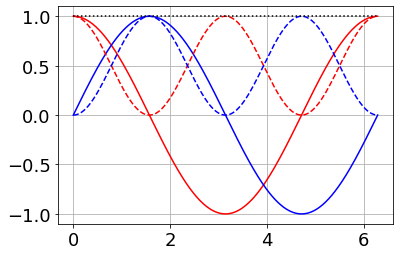

In [20]:
x=np.linspace(0,2*np.pi,500)

y1 = np.cos(x)
y2 = np.sin(x)
plt.plot(x,y1,'-r')
plt.plot(x,y2,'-b')
plt.grid(True)

plt.plot(x,y1**2,'--r')
plt.plot(x,y2**2,'--b')
plt.plot(x,np.sqrt(y1**2+y2**2),':k')

print('int |cos(x)| = ',np.mean(np.abs(y1)))
print('int |sin(x)| = ',np.mean(np.abs(y2)))

print('int cos(x)**2 = ',np.mean(y1**2))
print('int sin(x)**2 = ',np.mean(y2**2))
print('int cos(x)**2+sin(x)**2 = ',np.mean(y1**2+y2**2))
print('int sqrt(cos(x)**2+sin(x)**2) = ',np.mean(np.sqrt(y1**2+y2**2)))
print(np.mean(np.abs(y1))/np.mean(y1**2))


In [119]:
print(nx)

4048
